In [158]:
import numpy as np
import pandas as pd
import statistics as stat
from astropy.io import fits
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture # for GMM clustering
from sklearn import metrics # for calculating Silhouette score
from scipy.stats import norm
import time
import pymc3 as pm
import arviz as az

## 2. Analysis of data from CSV file

In [2]:
# Read in CSV file

df_cutoff = pd.read_csv('all_RVs.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df_cutoff

Target ID      Plate ID    MJD  \
0                             apo1m.1.Bestars.       Bestars  58017   
1                             apo1m.1.Bestars.       Bestars  58022   
2                    apo1m.1.calibration.VESTA   calibration  56398   
3                    apo1m.1.calibration.VESTA   calibration  56778   
4                         apo1m.1.calibration.   calibration  57743   
...                                        ...           ...    ...   
1730343  apo25m.4424.116-04.2M23595886+5726058          5583  56261   
1730344  apo25m.4424.116-04.2M23595886+5726058          5583  56284   
1730345  apo25m.4548.105-45.2M23595980+1528407          6560  56584   
1730346  apo25m.4548.105-45.2M23595980+1528407          6560  56588   
1730347  apo25m.4548.105-45.2M23595980+1528407          6560  56613   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)        <RV>        ΔRV  
0             -523.166440              0.234950 -525.619404   2.452961  
1             -526.084350              0.102290 -525.619404  -0.464947  
2               25.553330              0.018306   14.014931  11.538398  
3               10.561789              0.010014   14.014931  -3.453142  
4              -36.204376              0.003971  -36.204376   0.000000  
...                   ...                   ...         ...        ...  
1730343        -60.935745              0.012662  -60.924493  -0.011252  
1730344        -60.901040              0.019322  -60.924493   0.023454  
1730345         -5.201384              0.050281   -5.175535  -0.025849  
1730346         -5.034553              0.066701   -5.175535   0.140983  
1730347         -5.517447              0.126213   -5.175535  -0.341911  

[1730348 rows x 7 columns]

(80.0, -80.0)

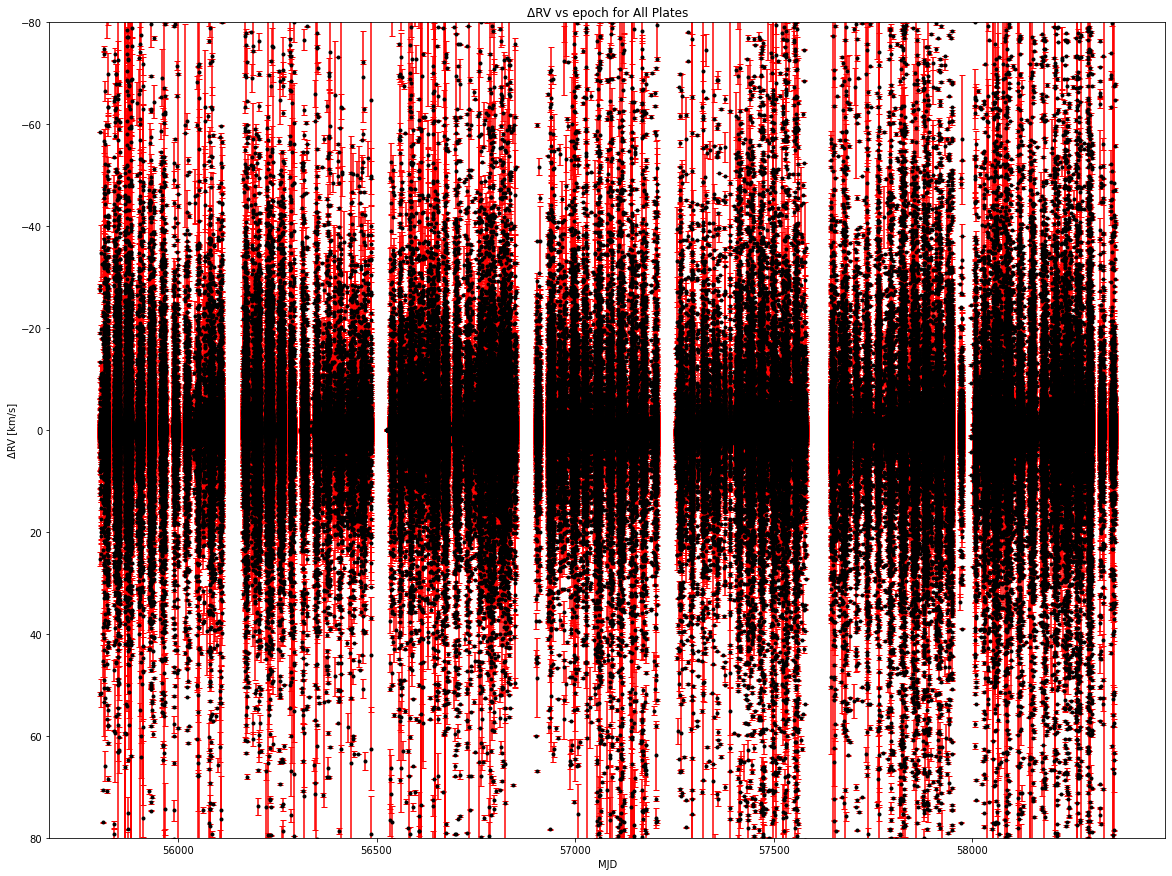

In [5]:
x = df_cutoff['MJD']
y = df_cutoff['ΔRV']
yerr = df_cutoff['OBSVREL Error (km/s)']
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, yerr, fmt='.', capsize=3, color='black', ecolor='r')
plt.title('ΔRV vs epoch for All Plates')
plt.xlabel('MJD')
plt.ylabel('ΔRV [km/s]')
plt.ylim(80, -80)

In [334]:
x = df_cutoff['MJD']
y = df_cutoff['ΔRV']
yerr = df_cutoff['OBSVREL Error (km/s)']
weight = 1/(yerr**2)

In [335]:
model, cov = np.polyfit(x, y, deg=1, w=weight, cov=True)
a, b = model

Text(0, 0.5, 'ΔRV [km/s]')

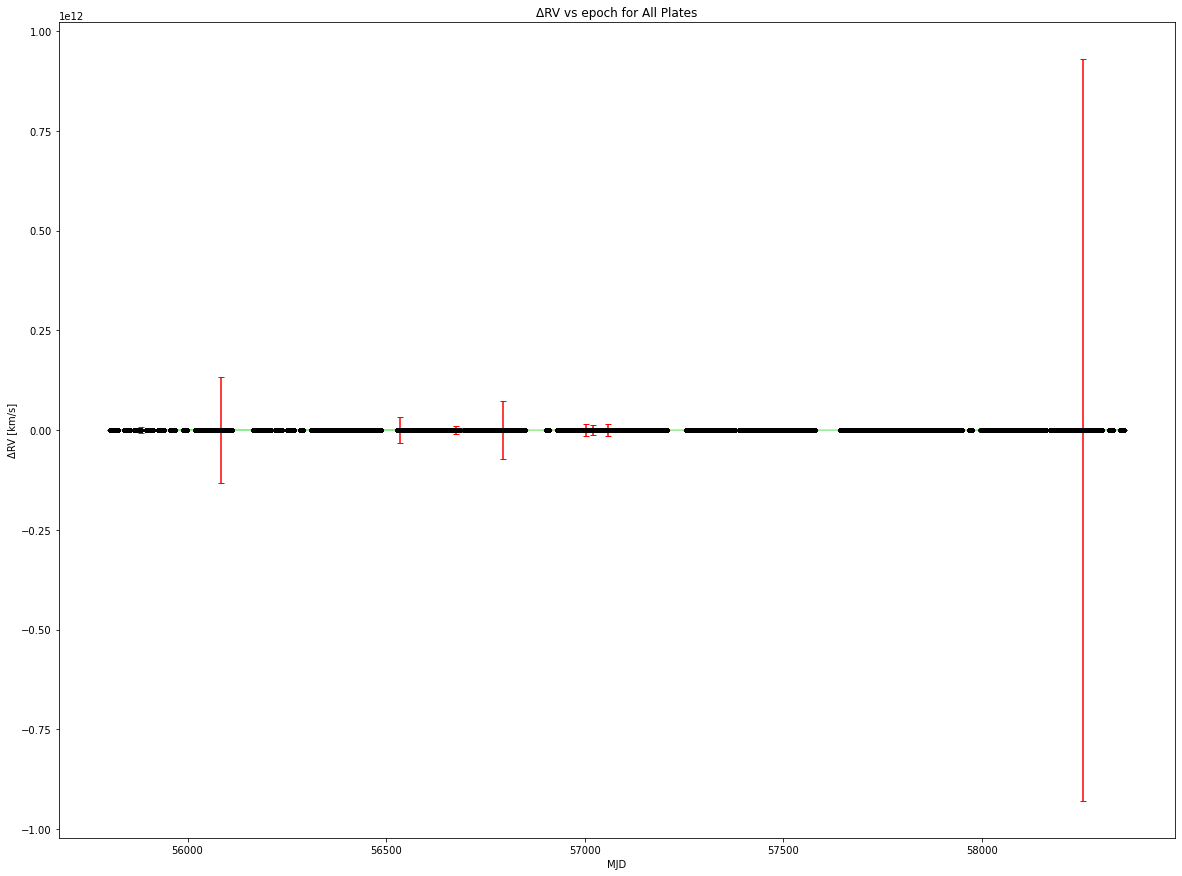

In [337]:
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, weight, fmt='.', capsize=3, color='black', ecolor='r')
plt.plot(x, a*x+b, color='lightgreen')
plt.title('ΔRV vs epoch for All Plates')
plt.xlabel('MJD')
plt.ylabel('ΔRV [km/s]')
#plt.ylim(80, -80)

In [338]:
print(a)
print(b)

2.4131344753463412e-06
-0.1407693371949993


In [ ]:
# Scatterplot of combined total ΔRVs per epoch, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='lightgreen')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/s/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

In [ ]:
# 7 day binning
n = 307
_b = -0.9148459495318688 #5.2373371053304645
_a = 0.011039173768061234 #-0.04843860912504228
_sigma = avg_weeks_w2
x = np.linspace(0, 306, 307)
y = _a*x + _b
yobs = avg_7d2

plt.scatter(x, yobs)
plt.plot(x, y)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    qs = np.sqrt(sigma**2 + np.array(_sigma)**2)
    
    likelihood = pm.Normal('y', mu=b+a*x, sigma=qs, observed=yobs)
    
    trace7d = pm.sample(10000, cores=16, return_inferencedata=True)

az.plot_trace(trace7d, figsize=(10, 7))
pm.plot_posterior(trace7d)

pm.summary(trace7d)

In [4]:
# Identify list of unique MJDs

unique_mjd = Counter(df_cutoff['MJD'])
unique_mjd_list = unique_mjd.keys()

In [5]:
len(unique_mjd_list)

1526

In [6]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs = []
combined_staterror = []
t1 = time.process_time()

for mjd in unique_mjd_list:
    mjd_df = df_cutoff[df_cutoff['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)']) #sigma = standard dev??
    #print('std:', mjd_sigma)
    #weight = 1/(mjd_sigma**2)
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight)) # potentially redundant calc?
    #combined_weightedavg = 1000*sum([mjd_RVs[r] * weight for r in range(len(mjd_RVs))]) / (weight * len(mjd_RVs))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    #print('combined weighted avg calc time:', (time.process_time()-t1))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs.append(combined_weightedavg)
    #print('combined avg append time:', (time.process_time()-t1))
    combined_staterror.append(sigmaRV)
    #print('combined stat error append time:', (time.process_time()-t1))
print('total time:', (time.process_time()-t1))

total time: 5.912781


In [7]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_data = [unique_mjd_list, combined_weightedRVs, combined_staterror]
weightedavg_df = pd.DataFrame(weightedavg_data).transpose()
weightedavg_df.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)']

In [8]:
weightedavg_df

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)
0     58017.0           18.532673            0.516441
1     58022.0           -7.037739            0.406064
2     56398.0           32.209356            0.390692
3     56778.0        -3390.358293            9.925159
4     57743.0            0.023227            2.212728
...       ...                 ...                 ...
1521  55870.0         -747.353620            0.877595
1522  56617.0          407.050243            1.423239
1523  56625.0          380.012824            0.524959
1524  56576.0           61.801196            0.568926
1525  56482.0          408.837184            0.694695

[1526 rows x 3 columns]

Gradient of slope: 0.07369522906907566 [m/MJD]
Polynomial coefficients: 0.07369522906907566 -4292.960080074415
Covariance matrix: [[ 1.43190827e-04 -8.33309895e+00]
 [-8.33309895e+00  4.84967464e+05]]
Uncertainty: [1.19662370e-02 6.96396054e+02]


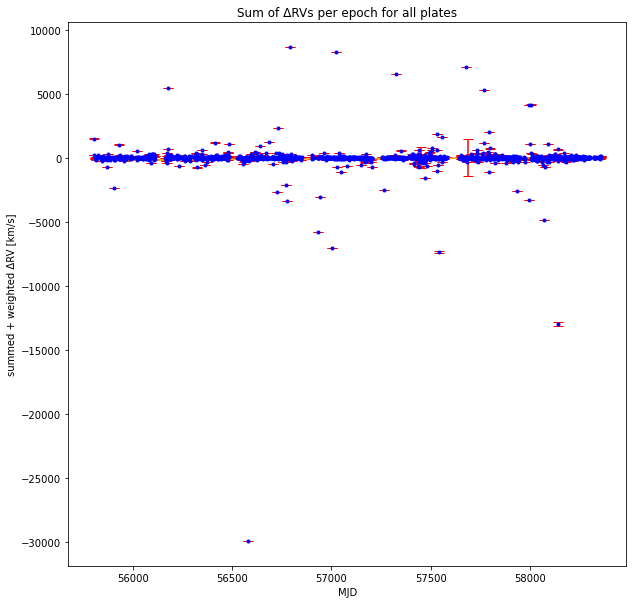

In [9]:
x_c = weightedavg_df['MJD']
y_c = weightedavg_df['Combined ΔRV (m/s)']
yerr_c = weightedavg_df['Combined σRV (m/s)']

weights = 1/(yerr_c**2)
model, cov = np.polyfit(x_c, y_c, deg=1, w=weights, cov=True)
a, b = model

# Scatterplot of combined total ΔRVs per epoch for all plates, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_c, y_c, yerr_c, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_c, a*x_c+b, color='orange')
plt.title('Sum of ΔRVs per epoch for all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [km/s]')

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

(-500.0, 500.0)

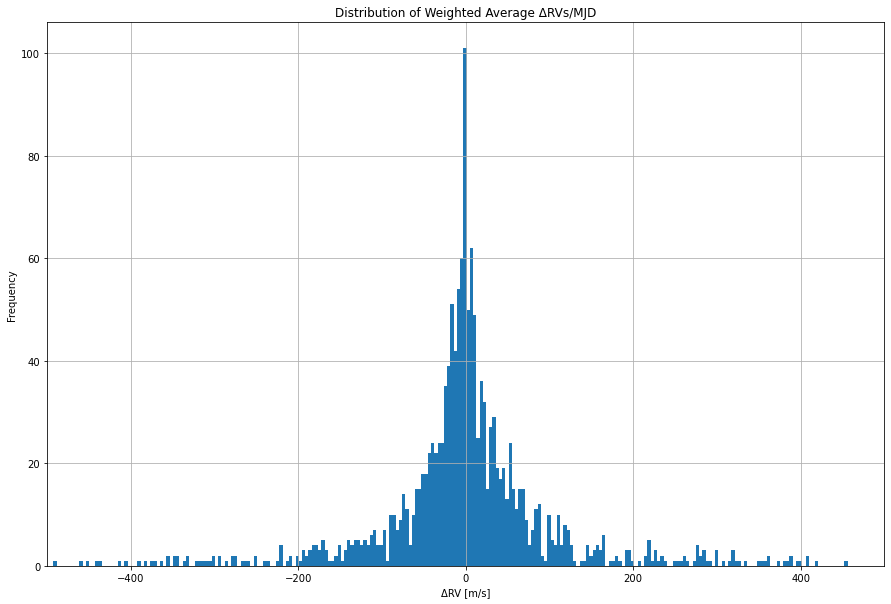

In [12]:
plt.figure(figsize=(15, 10))
weightedavg_df['Combined ΔRV (m/s)'].plot.hist(grid=True, bins=10000, rwidth=1)
plt.title('Distribution of Weighted Average ΔRVs/MJD')
plt.xlabel('ΔRV [m/s]')
plt.xlim(-500, 500)
#plt.ylim(0, 150000)

In [13]:
'''# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model
X = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()'''

"# Create empty list\nS=[]\n\n# Range of clusters to try (2 to 10)\nK=range(2,11)\n\n# Select data for clustering model\nX = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]\n\nfor k in K:\n    # Set the model and its parameters\n    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')\n    # Fit the model \n    labels = model.fit_predict(X)\n    # Calculate Silhoutte Score and append to a list\n    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))\n\n# Plot the resulting Silhouette scores on a graph\nplt.figure(figsize=(16,8), dpi=300)\nplt.plot(K, S, 'bo-', color='black')\nplt.xlabel('k')\nplt.ylabel('Silhouette Score')\nplt.title('Identify the number of clusters using Silhouette Score')\nplt.show()"

(0.0, 150000.0)

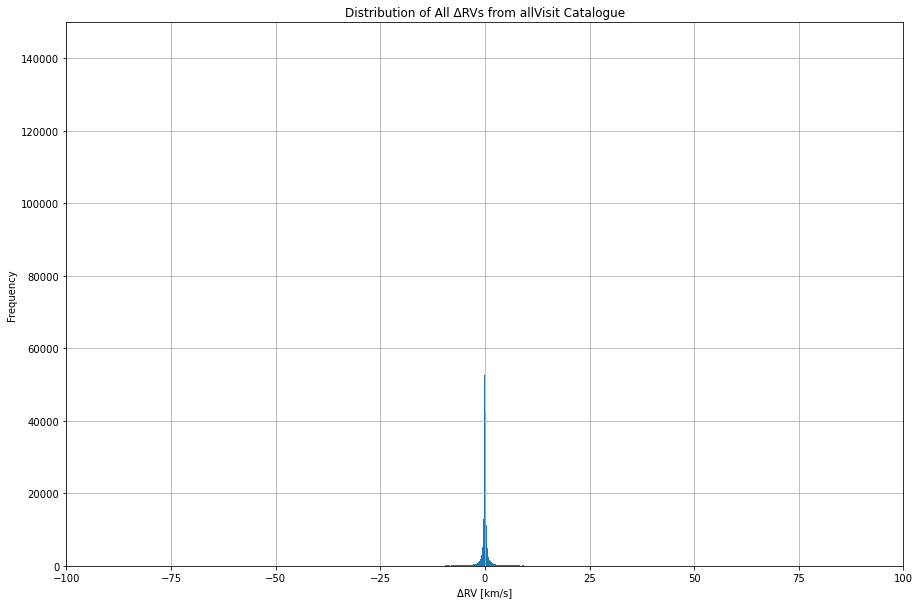

In [14]:
plt.figure(figsize=(15, 10))
df_cutoff['ΔRV'].plot.hist(grid=True, bins=100000, rwidth=1)
plt.title('Distribution of All ΔRVs from allVisit Catalogue')
plt.xlabel('ΔRV [km/s]')
plt.xlim(-100, 100)
plt.ylim(0, 150000)

In [10]:
# Select data for clustering model
X = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]

# Set the model and its parameters - 2 clusters
model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=1000, # the number of EM iterations to perform. default=100
                         n_init=10, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust2 = model.fit(X)
labels2 = model.predict(X)

# Generate 10,000 new samples based on the model
smpl=model.sample(n_samples=10000)

# Model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', clust2.weights_)
print('Means: ', clust2.means_)
print('Covariances: ', clust2.covariances_)
print('Precisions: ', clust2.precisions_)
#print('Precisions Cholesky: ', clust2.precisions_cholesky_)
print('Converged: ', clust2.converged_)
print(' No. of Iterations: ', clust2.n_iter_)
print('Lower Bound: ', clust2.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.9355188 0.0644812]
Means:  [[ 8.00270390e-02 -3.93727385e-03]
 [ 7.73090869e+07 -6.70191729e-01]]
Covariances:  [[[ 1.33798023e-02 -3.51228399e-04]
  [-3.51228399e-04  8.49121119e-01]]

 [[ 1.97096382e+20 -1.48532254e+10]
  [-1.48532254e+10  6.92250282e+03]]]
Precisions:  [[[7.47403316e+01 3.09154094e-02]
  [3.09154094e-02 1.17770108e+00]]

 [[5.07448038e-21 1.08880275e-14]
  [1.08880275e-14 1.44479785e-04]]]
Converged:  True
 No. of Iterations:  20
Lower Bound:  -2.7722653822646355


In [11]:
# Attach cluster labels to the main dataframe
df_cutoff['Cluster']=labels2

In [12]:
df0 = df_cutoff[df_cutoff['Cluster'] == 0]
df1 = df_cutoff[df_cutoff['Cluster'] == 1]

In [13]:
df0

Target ID      Plate ID    MJD  \
0                             apo1m.1.Bestars.       Bestars  58017   
1                             apo1m.1.Bestars.       Bestars  58022   
3                    apo1m.1.calibration.VESTA   calibration  56778   
4                         apo1m.1.calibration.   calibration  57743   
5        apo25m.5046.120+12.2M00000002+7417074          7545  56933   
...                                        ...           ...    ...   
1730343  apo25m.4424.116-04.2M23595886+5726058          5583  56261   
1730344  apo25m.4424.116-04.2M23595886+5726058          5583  56284   
1730345  apo25m.4548.105-45.2M23595980+1528407          6560  56584   
1730346  apo25m.4548.105-45.2M23595980+1528407          6560  56588   
1730347  apo25m.4548.105-45.2M23595980+1528407          6560  56613   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)        <RV>       ΔRV  Cluster  
0             -523.166440              0.234950 -525.619404  2.452961        0  
1             -526.084350              0.102290 -525.619404 -0.464947        0  
3               10.561789              0.010014   14.014931 -3.453142        0  
4              -36.204376              0.003971  -36.204376  0.000000        0  
5              -51.673046              0.001443  -51.727627  0.054581        0  
...                   ...                   ...         ...       ...      ...  
1730343        -60.935745              0.012662  -60.924493 -0.011252        0  
1730344        -60.901040              0.019322  -60.924493  0.023454        0  
1730345         -5.201384              0.050281   -5.175535 -0.025849        0  
1730346         -5.034553              0.066701   -5.175535  0.140983        0  
1730347         -5.517447              0.126213   -5.175535 -0.341911        0  

[1618036 rows x 8 columns]

Text(0.5, 0, 'ΔRV [m/s]')

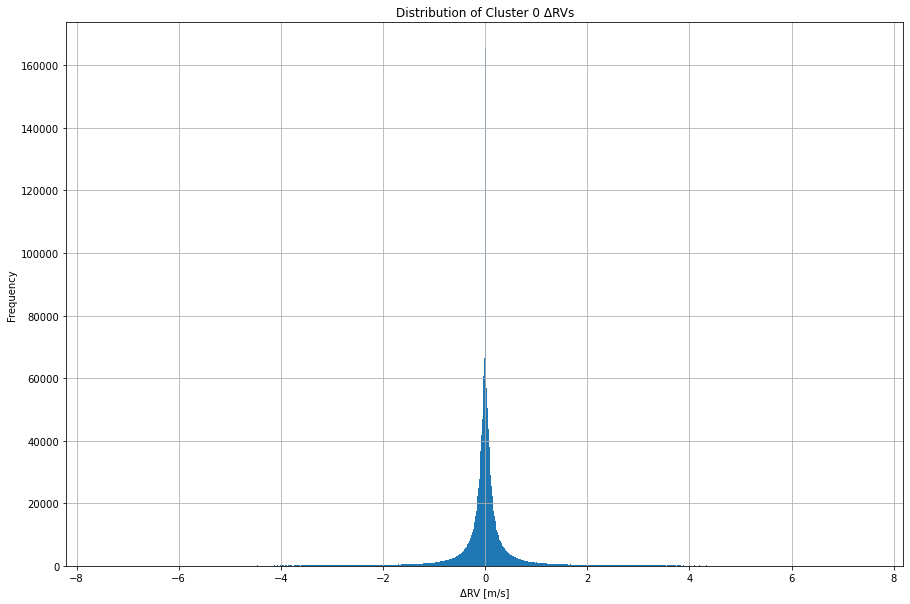

In [19]:
plt.figure(figsize=(15, 10))
df0['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1)
plt.title('Distribution of Cluster 0 ΔRVs')
plt.xlabel('ΔRV [m/s]')
#plt.xlim(-500, 500)
#plt.ylim(0, 150000)

mu: -0.003854314033457798 std: 0.9127881982888993


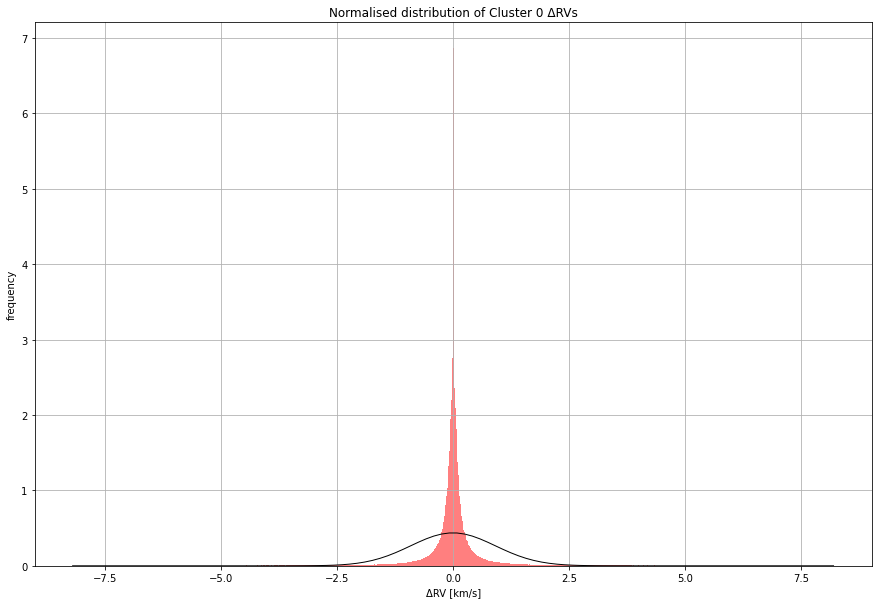

In [20]:
mu0, std0 = norm.fit(df0['ΔRV'])

plt.figure(figsize=(15,10))
plt.hist(x=df0['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 0', density=True)
xmin0, xmax0 = plt.xlim()
x0 = np.linspace(xmin0, xmax0, 100)
p0 = norm.pdf(x0, mu0, std0)  
plt.plot(x0, p0, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 0 ΔRVs')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu0, 'std:', std0)

Text(0.5, 0, 'ΔRV [m/s]')

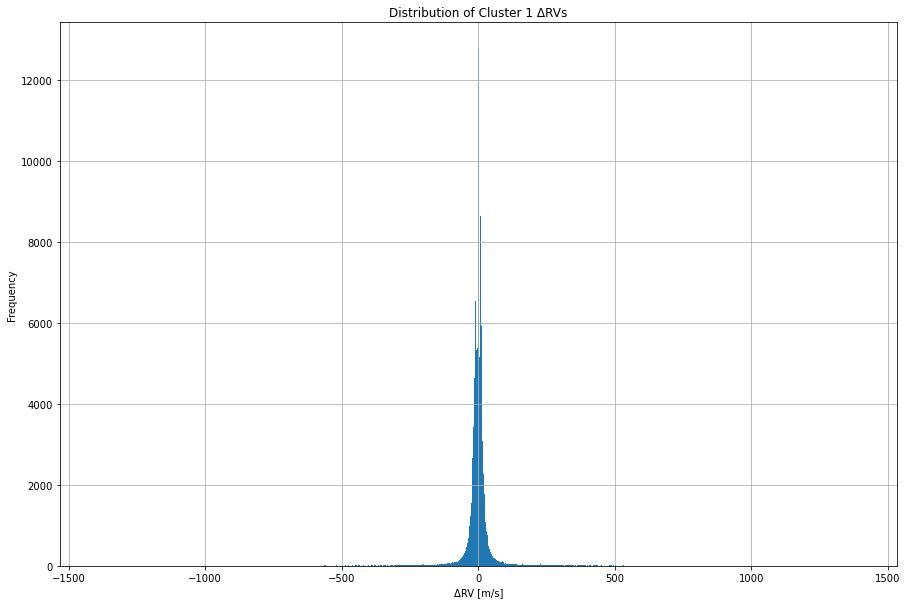

In [21]:
plt.figure(figsize=(15, 10))
df1['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1)
plt.title('Distribution of Cluster 1 ΔRVs')
plt.xlabel('ΔRV [m/s]')
#plt.xlim(-500, 500)
#plt.ylim(0, 150000)

mu: -0.6670143641727447 std: 82.92953568103464


(-500.0, 500.0)

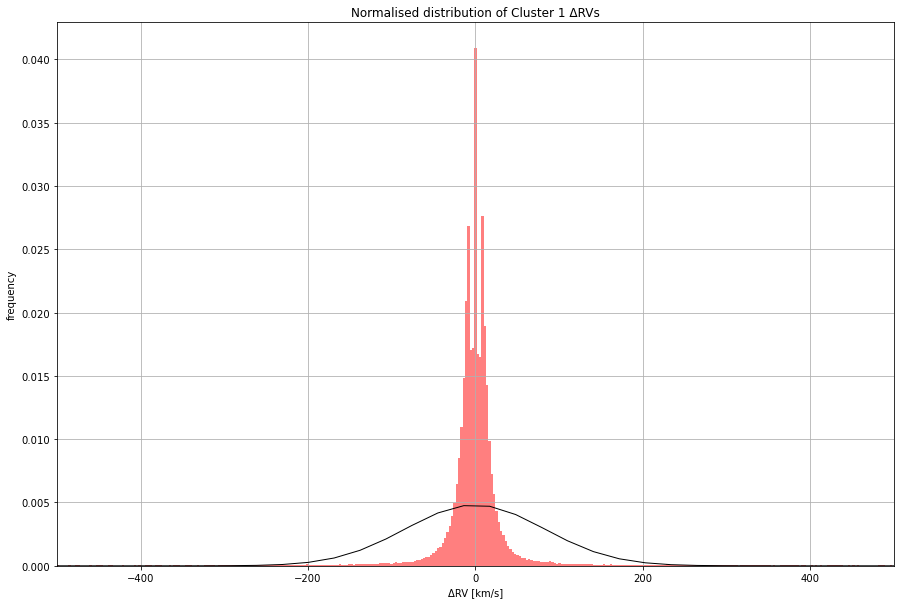

In [22]:
mu1, std1 = norm.fit(df1['ΔRV'])

plt.figure(figsize=(15,10))
plt.hist(x=df1['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 1', density=True)
xmin1, xmax1 = plt.xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)  
plt.plot(x1, p1, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 1 ΔRVs')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu1, 'std:', std1)
plt.xlim(-500, 500)

In [16]:
mu0, std0 = norm.fit(df0['ΔRV'])

In [17]:
mu0

-0.003854314033457798

In [18]:
std0

0.9127881982888993

In [19]:
# 95th percentile larger than before?
np.sort(list(np.random.normal(0, std0, 10000000)))[500000]

-1.50126924536575

In [20]:
# Consider limiting ΔRV range?

df_cut = df_cutoff.loc[(df_cutoff['ΔRV'] < 1.5006843841275197) & (df_cutoff['ΔRV'] > -1.5006843841275197)]
#df_cutoff = df.loc[(df['ΔRV'] < 1) & (df['ΔRV'] > -1)]
df_cut.sort_values('ΔRV')

Target ID      Plate ID    MJD  \
840284       lco25m.5254.300-12.2M12074713-7400204          9701  57881   
101171   apo25m.2396.146-46_MGA.2M02002840+1313279          9195  57662   
182918   apo25m.2302.194-44_MGA.2M03402491-0658283          8727  57691   
1688018    lco25m.5448.051-50-O.2M22162068-0923066          9994  58033   
921990       apo25m.5181.120+45.2M13071823+7307590          9068  57827   
...                                            ...           ...    ...   
324417       apo25m.4559.169+04.2M05323978+4101162          6541  56257   
692012     apo25m.5126.ORPHAN-4.2M09554604+3734466          8472  57094   
1020482      apo25m.5186.090+60.2M14253104+4921363          9005  57498   
714004     apo25m.5119.ORPHAN-2.2M10232934+1411052          8120  57056   
1672718      apo25m.5154.100+00.2M21521428+5428429          8691  57652   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)       <RV>       ΔRV  Cluster  
840284           7.127516              0.160403   8.628178 -1.500662        0  
101171          -7.345494              0.069228  -5.844890 -1.500604        0  
182918           0.399978              0.051881   1.900527 -1.500548        0  
1688018         34.684708              0.031783  36.185223 -1.500515        0  
921990         -20.090202              0.203785 -18.589717 -1.500486        0  
...                   ...                   ...        ...       ...      ...  
324417          -2.179410              0.456571  -3.680050  1.500640        0  
692012          21.122200              0.466716  19.621553  1.500647        0  
1020482        -10.880820              0.317963 -12.381471  1.500651        0  
714004         -31.397923              0.298479 -32.898576  1.500653        0  
1672718        -25.788550              0.111122 -27.289217  1.500667        0  

[1537042 rows x 8 columns]

In [21]:
# Identify list of unique MJDs

unique_mjd_cut = Counter(df_cut['MJD'])
unique_mjd_cutlist = unique_mjd_cut.keys()

## Q
1. sqrt(1/n*(sum(x_i^2)))

In [22]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs_cut = []
combined_staterror_cut = []
weights_cut = []
rmserr_cut = []
std_cut = []
stdalt_cut = []
t2 = time.process_time()
weights_stdcut = []

for mjd in unique_mjd_cutlist:
    mjd_df = df_cut[df_cut['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    """3 ways of calculating same thing, all <20?"""
    mean = sum(mjd_RVs) / len(mjd_RVs)
    std = np.sqrt(sum((r - mean)**2 for r in mjd_RVs) / len(mjd_RVs))
    std_alt = np.array(mjd_RVs).std()
    if std_alt > 0:
        weights_std = 1/std_alt**2
        weights_stdcut.append(weights_std)
    else:
        weights_stdcut.append(0)
    rmserr = np.sqrt(((sum(mjd_RVs[r]**2 for r in range(len(mjd_RVs))))/len(mjd_RVs))/len(mjd_RVs))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs_cut.append(combined_weightedavg)
    combined_staterror_cut.append(sigmaRV)
    weights_cut.append(weight)
    rmserr_cut.append(rmserr)
    std_cut.append(std)
    stdalt_cut.append(std_alt)
print('total time:', (time.process_time()-t2))

total time: 6.368079000000023


In [23]:
weights_stdcut

[9.738177562092183,
 1353.9215417976827,
 26.967953529548513,
 15.049881064130373,
 14.94303429572048,
 10.586001096306159,
 6.477900246068415,
 14.773246706971058,
 16.48436084051391,
 8.728376195786652,
 9.07840022042318,
 10.12133867017005,
 11.288633646620939,
 10.60377214641507,
 11.269634615990386,
 8.623538977155837,
 14.026857150484405,
 9.882219568430559,
 14.530246434235114,
 8.417025740166972,
 12.224393589649239,
 14.05229816789282,
 10.87212676197652,
 12.98082086092218,
 8.573575369583104,
 9.781684230335081,
 12.637583144324452,
 14.79910541582506,
 8.748255275740439,
 14.362616507551213,
 10.896996585269704,
 10.56855660027454,
 11.15187609205047,
 8.349146271962644,
 10.116202553500692,
 19.31906191208143,
 11.530386147970033,
 18.317857120625398,
 9.494766554812925,
 9.683352689639824,
 12.864055894071544,
 9.996374667074258,
 13.755932402596613,
 15.483582667031218,
 11.99795779676646,
 7.5093278541644395,
 12.512464276914836,
 9.556586632211745,
 11.54153992640699,


In [24]:
mjd57881 = df_cut[df_cut['MJD']==57881]
mjd57881

Target ID      Plate ID    MJD  \
759537         apo25m.5178.240+60.2M10573799+1102293          9682  57881   
759589         apo25m.5178.240+60.2M10573825+1114000          9682  57881   
759684         apo25m.5178.240+60.2M10574087+1130447          9682  57881   
759845         apo25m.5178.240+60.2M10574676+1121427          9682  57881   
760072         apo25m.5178.240+60.2M10575441+1050479          9682  57881   
...                                              ...           ...    ...   
1495379  apo25m.5202.K2_C7_009-18.2M19234085-2901541          9097  57881   
1495863  apo25m.5202.K2_C7_009-18.2M19234924-2854532          9097  57881   
1496210  apo25m.5202.K2_C7_009-18.2M19235873-2842140          9097  57881   
1496326  apo25m.5202.K2_C7_009-18.2M19240029-2837216          9097  57881   
1496414  apo25m.5202.K2_C7_009-18.2M19240141-2858186          9097  57881   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)       <RV>       ΔRV  Cluster  
759537          16.843248              0.100377  16.931473 -0.088225        0  
759589          -5.609581              0.094854  -5.752461  0.142880        0  
759684          57.916000              0.133084  58.528448 -0.612448        0  
759845           7.983303              0.111230   7.732044  0.251259        0  
760072          10.720554              0.133484  10.522347  0.198207        0  
...                   ...                   ...        ...       ...      ...  
1495379         83.023570              0.038404  83.128125 -0.104558        0  
1495863         51.318610              0.049897  51.262725  0.055886        0  
1496210         37.842514              0.169680  37.187507  0.655007        0  
1496326          1.709478              0.118738   1.640822  0.068656        0  
1496414        -70.199220              0.152802 -70.342590  0.143371        0  

[2131 rows x 8 columns]

In [25]:
sumsq = sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))
print('sum of x_i squared=', sumsq)
n = len(list(mjd57881['ΔRV']))
print('n=', n)
rms = sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))*1/len(list(mjd57881['ΔRV']))
print('rms=', rms)
err = rms/np.sqrt(len(list(mjd57881['ΔRV'])))

sum of x_i squared= 347.12006144828916
n= 2131
rms= 0.16289069049661623


In [26]:
len(list(mjd57881['ΔRV']))

2131

In [27]:
sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))*1/len(list(mjd57881['ΔRV']))

0.16289069049661623

In [28]:
np.sqrt(0.16289069049661623)

0.40359718841515263

In [29]:
np.sqrt(2131)

46.16275555033516

In [30]:
np.sqrt(0.16289069049661623)/np.sqrt(2131)

0.008742918042989796

In [76]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_cutdata = [unique_mjd_cutlist, combined_weightedRVs_cut, combined_staterror_cut, stdalt_cut, weights_stdcut]#, rmserr_cut]
weightedavg_df_cutoff = pd.DataFrame(weightedavg_cutdata).transpose()
weightedavg_df_cutoff.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)', 'std', 'weight']#, 'rmserr']

In [77]:
weightedavg_df_cutoff

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std       weight
0     58022.0           -8.053015            0.407374  0.320451     9.738178
1     57743.0            0.023227            2.212728  0.027177  1353.921542
2     56933.0            9.254238            0.147462  0.192564    26.967954
3     56936.0           23.920864            0.095845  0.257771    15.049881
4     56971.0         -178.377692            0.062524  0.258691    14.943034
...       ...                 ...                 ...       ...          ...
1519  55870.0          -73.029691            0.946294  0.348151     8.250209
1520  56617.0           62.421917            1.511150  0.432546     5.344839
1521  56625.0           11.459281            0.557512  0.309172    10.461668
1522  56576.0           58.248624            0.569609  0.247437    16.333159
1523  56482.0          305.706376            0.724491  0.387252     6.668252

[1524 rows x 5 columns]

### Convert Weighted Average Dataframe to CSV File

In [78]:
weightedavg_df_cutoff.to_csv('weightedavg_RVs.csv')

5.550691334364116e-17
-3.1265121136414375e-12


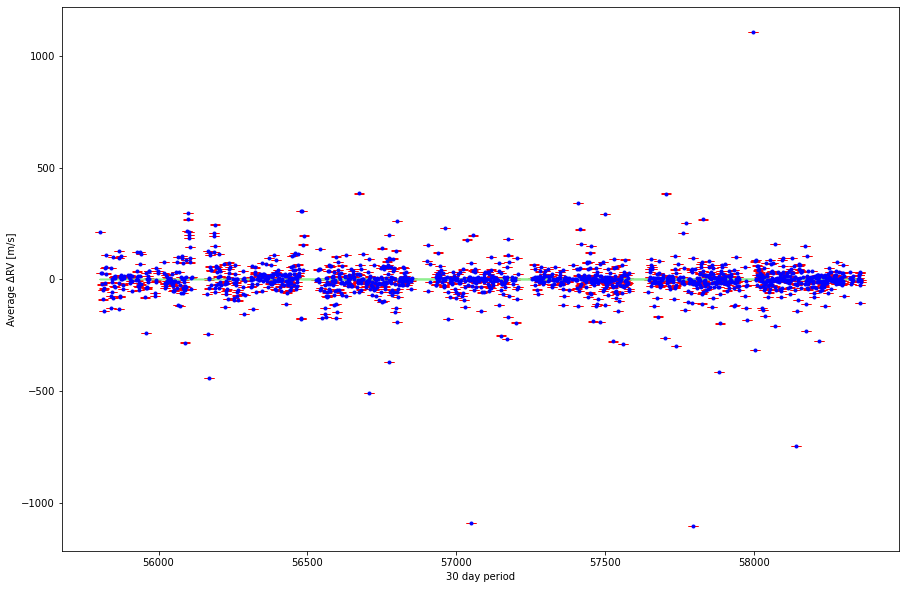

In [80]:
# Define cutoff scatterplot parameters

x_cf = weightedavg_df_cutoff['MJD']
y_cf = weightedavg_df_cutoff['Combined ΔRV (m/s)']
#yerr_cf = weightedavg_df_cutoff['Combined σRV (m/s)']
yerr_cf = weightedavg_df_cutoff['std']
weights = weightedavg_df_cutoff['weight']
a, b = np.polyfit(x_cf, y_cf, 1, w=weights)

plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
#plt.title('ΔRVs per 30 days w/ OBSVRELERR error')
#plt.title('ΔRVs per 30 days w/ std error')
print(a)
print(b)

0.0984578364472153
-1.8985966495637852


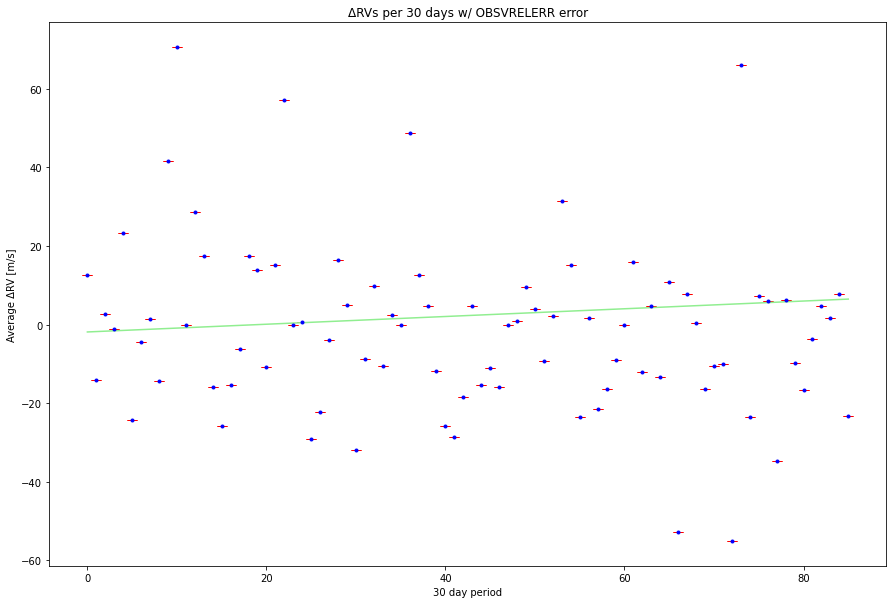

In [81]:
x = np.arange(0,86)
y = avg_30d
yerr = avg_30d_w
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days w/ OBSVRELERR error')
#plt.title('ΔRVs per 30 days w/ std error')
print(a)
print(b)

Gradient of slope: 5.550691334364116e-17 [m/s/MJD]
Polynomial coefficients: 5.550691334364116e-17 -3.1265121136414375e-12
Covariance matrix: [[ 2.05844229e-35 -1.16689013e-30]
 [-1.16689013e-30  6.61486907e-26]]
Uncertainty: [4.53700594e-18 2.57193878e-13]


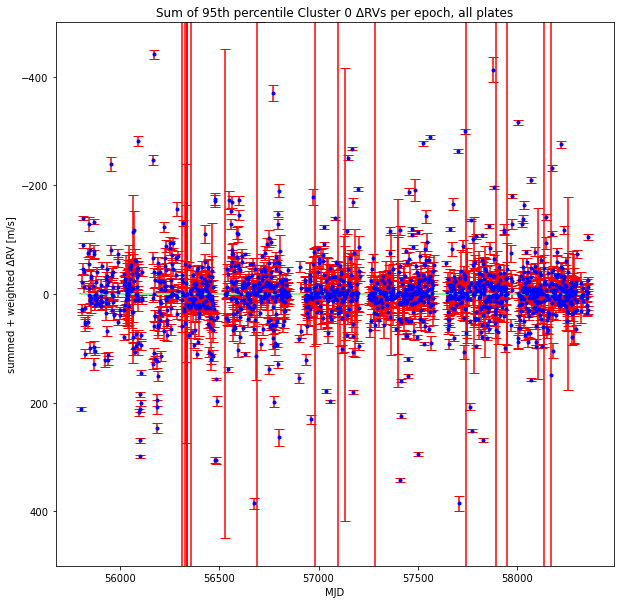

In [82]:
'''weights = []
for e in yerr_cf:
    if e == 0:
        print(e)
        weight = 0.0
        weights.append(weight)
    else:
        weight = 1/(yerr_cf)**2
        weights.append(weight)'''

model, cov = np.polyfit(x_cf, y_cf, deg=1, w=weights, cov=True)
a, b = model

# Scatterplot of combined total ΔRVs per epoch, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, weights, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='lightgreen')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/s/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, b, a]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 119 seconds.
The acceptance probability does not match the target. It is 0.8812625350506491, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837660189683831, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      -0.047  0.015  -0.075   -0.019      0.000    0.000   75283.0   80221.0   
b       4.912  2.609   0.065    9.844      0.010    0.007   74800.0   80023.0   
sigma  23.115  0.446  22.286   23.959      0.001    0.001   92617.0   86549.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

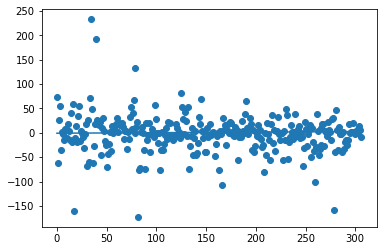

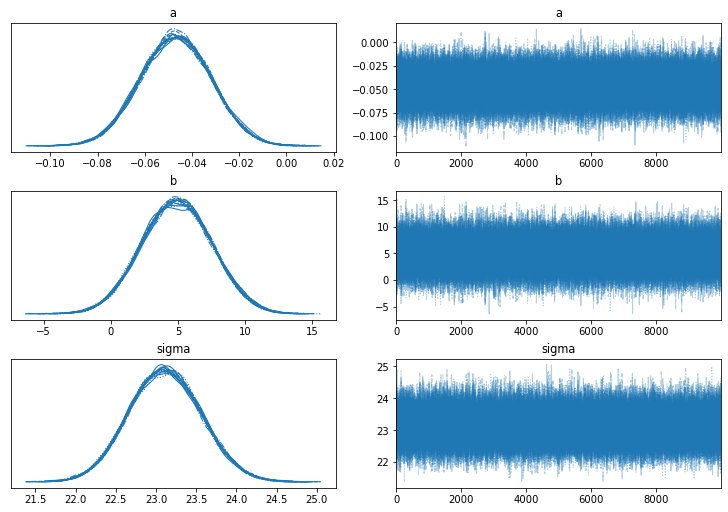

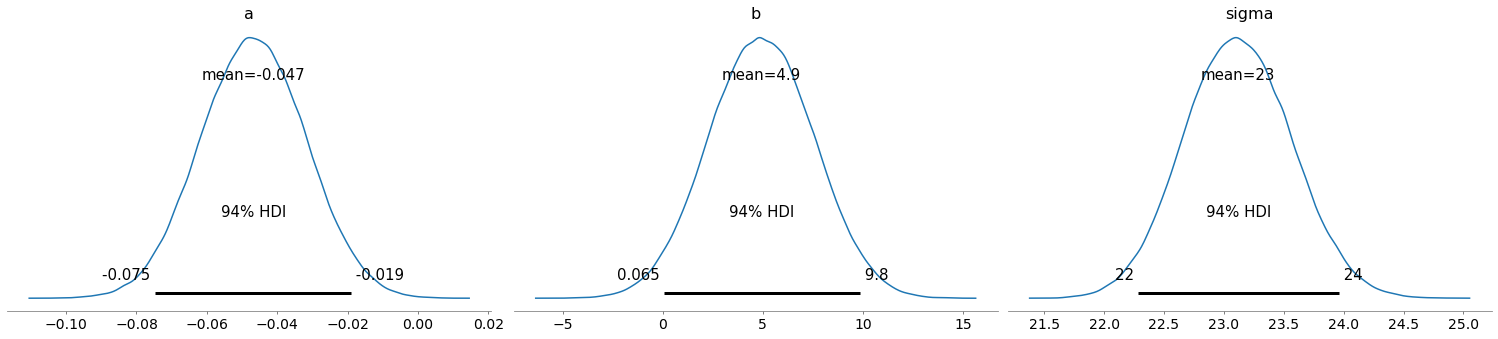

In [160]:
# 7 day binning
n = 307
_b = -0.9148459495318688 #5.2373371053304645
_a = 0.011039173768061234 #-0.04843860912504228
_sigma = avg_weeks_w2
x = np.linspace(0, 306, 307)
y = _a*x + _b
yobs = avg_7d2

plt.scatter(x, yobs)
plt.plot(x, y)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    tau = 1/(sigma**2 + np.array(avg_)**2)
    
    likelihood = pm.Normal('y', mu=b+a*x, tau=tau, observed=yobs)
    
    trace7d = pm.sample(10000, cores=16, return_inferencedata=True)

az.plot_trace(trace7d, figsize=(10, 7))
pm.plot_posterior(trace7d)

pm.summary(trace7d)

mu: -2.351556728498106 std: 84.57216100077585


(-200.0, 200.0)

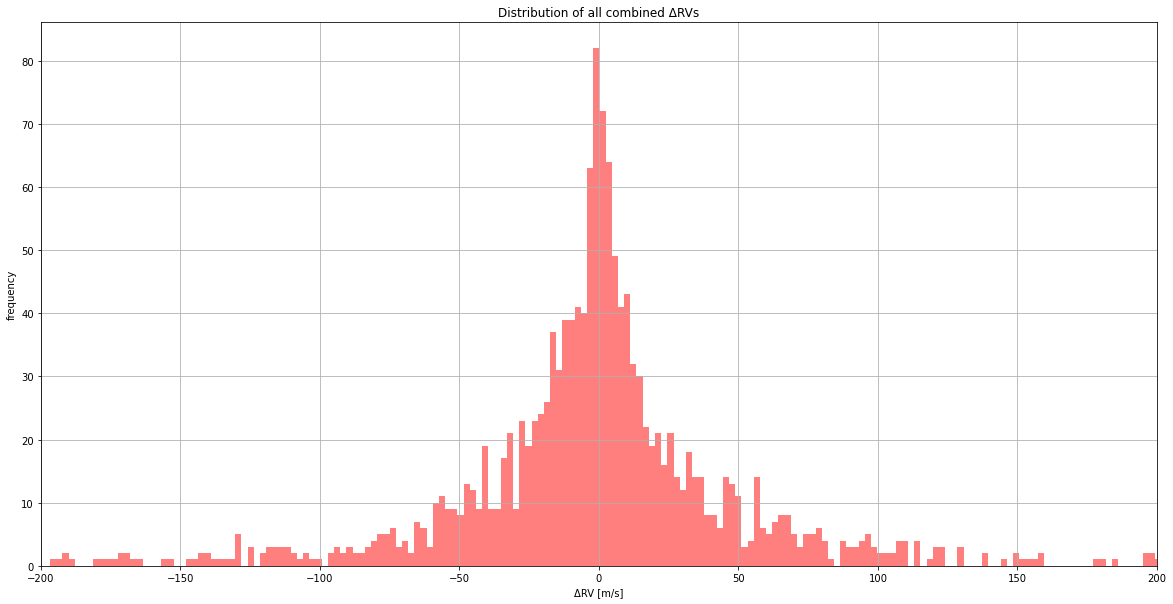

In [83]:
# Normalised weighted distribution of all combined ΔRVs

mua, stda = norm.fit(weightedavg_df_cutoff['Combined ΔRV (m/s)'])

plt.figure(figsize=(20,10))
plt.hist(x=weightedavg_df_cutoff['Combined ΔRV (m/s)'], bins=1000, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
plt.xlim(-200, 200)

In [84]:
# Select data for clustering model
X = weightedavg_df_cutoff[['Combined ΔRV (m/s)', 'Combined σRV (m/s)']]

# Set the model and its parameters - 2 clusters
model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=1000, # the number of EM iterations to perform. default=100
                         n_init=10, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust2 = model.fit(X)
labels2 = model.predict(X)

# Generate 10,000 new samples based on the model
smpl=model.sample(n_samples=10000)

# Model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', clust2.weights_)
print('Means: ', clust2.means_)
print('Covariances: ', clust2.covariances_)
print('Precisions: ', clust2.precisions_)
#print('Precisions Cholesky: ', clust2.precisions_cholesky_)
print('Converged: ', clust2.converged_)
print(' No. of Iterations: ', clust2.n_iter_)
print('Lower Bound: ', clust2.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.91492412 0.08507588]
Means:  [[-1.66405808  0.44629466]
 [-9.74506315 26.29020088]]
Covariances:  [[[ 1.97838061e+03 -6.13669110e-01]
  [-6.13669110e-01  7.36887526e-02]]

 [[ 6.27357484e+04  4.72861256e+02]
  [ 4.72861256e+02  2.22852701e+04]]]
Precisions:  [[[ 5.06773004e-04  4.22033115e-03]
  [ 4.22033115e-03  1.36057383e+01]]

 [[ 1.59424249e-05 -3.38275239e-07]
  [-3.38275239e-07  4.48798670e-05]]]
Converged:  True
 No. of Iterations:  10
Lower Bound:  -6.2888518305819385


In [85]:
# 95th percentile larger than before?
# Attach cluster labels to the main dataframe
weightedavg_df_cutoff['Cluster']=labels2
df0 = weightedavg_df_cutoff[weightedavg_df_cutoff['Cluster'] == 0]
df1 = weightedavg_df_cutoff[weightedavg_df_cutoff['Cluster'] == 1]
#df0
mu0, std0 = norm.fit(df0['Combined ΔRV (m/s)'])
np.sort(list(np.random.normal(0, std0, 10000000)))[500000]

-73.00982292622562

In [86]:
y0 = df0['Combined ΔRV (m/s)']
y1 = df1['Combined ΔRV (m/s)']
x0 = df0['MJD']
x1 = df1['MJD']

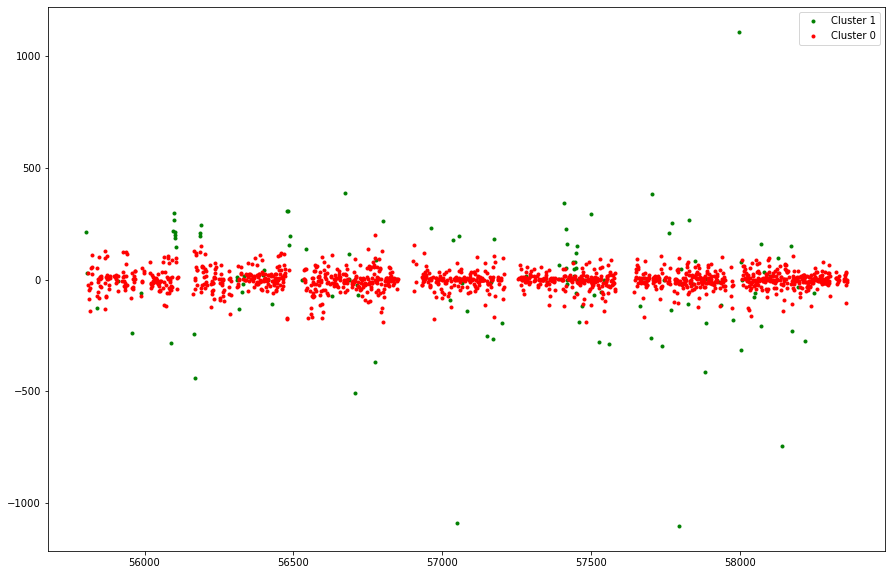

In [87]:
plt.figure(figsize=(15, 10))
plt.plot(x1, y1, '.', color='g', label='Cluster 1')
plt.plot(x0, y0, '.', color='r', label='Cluster 0')
plt.legend()

- try binning (weighted avg all points within a month/week)
- try looking at histogram of all these points to get better sense of things
- try smoothing it (10m/s structure)
- write up what has been done so far
- look at |50m/s| cases --> error may only pop up on some of the plates
- plot looks like combination of 2 cases
- can look at plates 
- n data points, group them in some subsets, fit function to those subsets (box-car average)

## Convert MJD to weeks and months

In [88]:
from astropy import units as u
from astropy.time import Time
from tintervals import conversion

In [89]:
# Convert MJD to weeks and months for df_cut

converted_iso0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2iso(mjd)
    converted_iso0.append(convert)
    
converted_epoch_wk0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7)
    min_t = 2173.8571428571427
    weeks = convert - min_t
    converted_epoch_wk0.append(weeks)
    
converted_epoch_m0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*30)
    min_t = 507.23333333333335
    months = convert - min_t
    converted_epoch_m0.append(months)
    
# Convert MJD to weeks and months for weightedavg_df_cutoff

converted_iso = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2iso(mjd)
    converted_iso.append(convert)

converted_epoch_wk = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7)
    min_t = 2173.8571428571427
    weeks = convert - min_t
    converted_epoch_wk.append(weeks)

converted_epoch_m = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*30)
    min_t = 507.23333333333335
    months = convert - min_t
    converted_epoch_m.append(months)

In [90]:
# Test ΔRVs per 4 weeks

converted_epoch_4wks = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7*4)
    min_t = 543.4642857142857
    weeks = convert - min_t
    converted_epoch_4wks.append(weeks)

In [91]:
# Attach time labels to the main dataframe

df_cut['ISO']=converted_iso0
df_cut['Weeks']=converted_epoch_wk0
df_cut['Months']=converted_epoch_m0

# Attach cluster labels to the weightedavg dataframe
weightedavg_df_cutoff['ISO']=converted_iso
weightedavg_df_cutoff['Weeks']=converted_epoch_wk
weightedavg_df_cutoff['4 Weeks']=converted_epoch_4wks
weightedavg_df_cutoff['Months']=converted_epoch_m

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_1044/4290082414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['ISO']=converted_iso0
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_1044/4290082414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['Weeks']=converted_epoch_wk0
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_1044/4290082414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [92]:
weightedavg_df_cutoff

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std       weight  \
0     58022.0           -8.053015            0.407374  0.320451     9.738178   
1     57743.0            0.023227            2.212728  0.027177  1353.921542   
2     56933.0            9.254238            0.147462  0.192564    26.967954   
3     56936.0           23.920864            0.095845  0.257771    15.049881   
4     56971.0         -178.377692            0.062524  0.258691    14.943034   
...       ...                 ...                 ...       ...          ...   
1519  55870.0          -73.029691            0.946294  0.348151     8.250209   
1520  56617.0           62.421917            1.511150  0.432546     5.344839   
1521  56625.0           11.459281            0.557512  0.309172    10.461668   
1522  56576.0           58.248624            0.569609  0.247437    16.333159   
1523  56482.0          305.706376            0.724491  0.387252     6.668252   

      Cluster                   ISO       Weeks    4 Weeks     Months  
0           0  2017-09-26T00:00:00Z  316.857143  79.214286  73.933333  
1           1  2016-12-21T00:00:00Z  277.000000  69.250000  64.633333  
2           0  2014-10-03T00:00:00Z  161.285714  40.321429  37.633333  
3           0  2014-10-06T00:00:00Z  161.714286  40.428571  37.733333  
4           0  2014-11-10T00:00:00Z  166.714286  41.678571  38.900000  
...       ...                   ...         ...        ...        ...  
1519        0  2011-11-05T00:00:00Z    9.428571   2.357143   2.200000  
1520        0  2013-11-21T00:00:00Z  116.142857  29.035714  27.100000  
1521        0  2013-11-29T00:00:00Z  117.285714  29.321429  27.366667  
1522        0  2013-10-11T00:00:00Z  110.285714  27.571429  25.733333  
1523        1  2013-07-09T00:00:00Z   96.857143  24.214286  22.600000  

[1524 rows x 10 columns]

In [93]:
max(list(weightedavg_df_cutoff['Weeks']))#.sort_values()

364.8571428571431

## Plot ΔRVs per week

In [94]:
n = 0
p = 1
avg_weeks = []
avg_weeks_err = []
avg_weeks_w = []
for i in range(0, 365):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Weeks'] >= n) & (weightedavg_df_cutoff['Weeks'] < p)]
    #print(period)
    weight = len(period['Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_weeks.append(avg)

        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight #if not divided by N, then order of 1; if divided, then order of 0.1??
        if avg_err == 0:
            print(avg_err)
            avg_weeks_err.append(avg_err)
        else:
            avg_weeks_err.append(1/avg_err**2)
            #avg_weeks_w.append(w)

        std = np.array(period['Combined ΔRV (m/s)']).std()
        if std == 0:
            print(std)
            avg_weeks_w.append(std)
        else:
            w = 1/std**2
            print(w)
            avg_weeks_w.append(w)        
    else:
        avg_weeks.append(0)
        avg_weeks_err.append(0)
        avg_weeks_w.append(0)
    n = n+1
    p = p+1

9.906022398287137e-05
0.00026428735883885884
0.00036642446592224915
0.0
0.0002975630760709592
0.0003432760598632948
0.002193279700052886
0.0
0.00010579785062141452
0.019566767904668332
0.0018845344521011538
0.0
0.0056831369483958324
0.0012728638443089944
0.00041500034051922084
0.0023888728153672245
0.00032331715588050755
0.00015889864617452058
0.0013447396283225528
0.002436004252213052
0.0005156921051507154
0.0639153637018021
0.0016281150739899087
0.0030327313068631017
0.013753041298891084
0.03992246412730921
0.004055219850193726
0.002621891698463789
0.0008124408764297938
0.00017305562664687293
0.0006892050856790419
0.0002642390617738811
0.00011528147910517411
0.00010914901698702151
0.0005311805904268945
0.00025910994855334307
4.2745646075634444e-05
3.173129302752104e-05
0.0010124423412096095
0.0005019069665276006
0.00022539165255714512
0.0010850288258508168
0.00038957529964105673
0.0005087981452250746
0.0007094657702611742
0.0004237323415798609
0.0016201143678871183
0.0
0.000310896377

In [95]:
len(avg_weeks_w)

365

0.009606536879209229
-1.0100772858413702


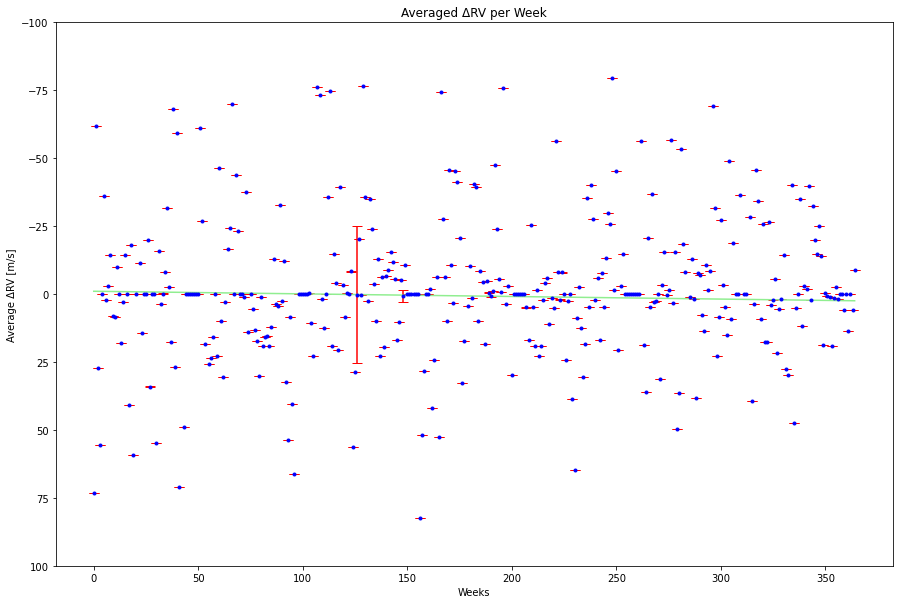

In [96]:
x = np.arange(0,365)
y = avg_weeks
yerr = avg_weeks_w
#yerr = avg_weeks_err # 1/σ^2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('Weeks')
plt.ylabel('Average ΔRV [m/s]')
plt.title('Averaged ΔRV per Week')
plt.ylim(100, -100)
print(a)
print(b)

mu: -0.1987497745755401 std: 69.64674352762326


(-200.0, 200.0)

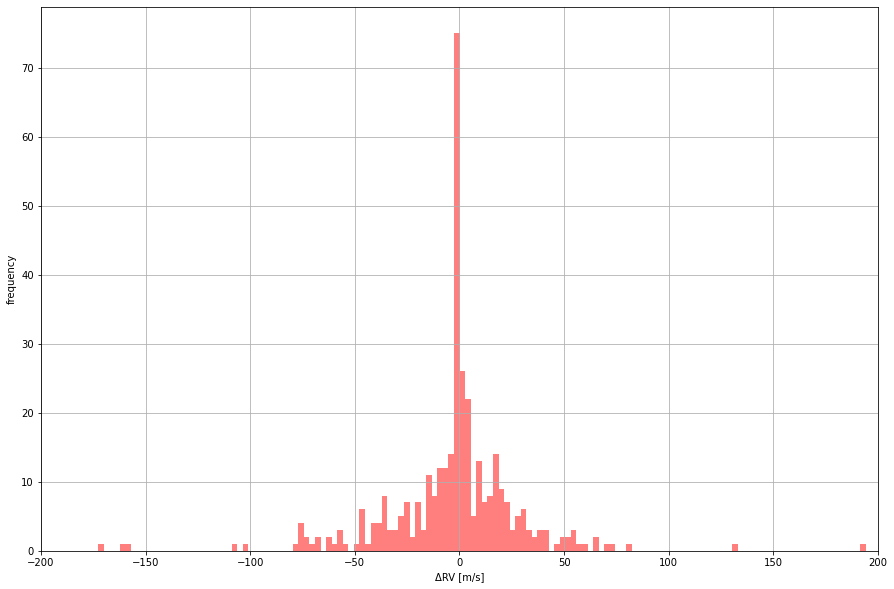

In [97]:
# Distribution of all combined ΔRVs

mua, stda = norm.fit(avg_weeks)

plt.figure(figsize=(15,10))
plt.hist(x=avg_weeks, bins=500, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
#plt.title('Normalised weighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
plt.xlim(-200, 200)

## Plot Average ΔRV per 4 Weeks

In [98]:
# Calculate average per 4 weeks + average error per 4 weeks

n = 0
p = 1
avg_4weeks = []
avg_4weeks_err = []
avg_4weeks_w = []
for i in range(0, 92):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['4 Weeks'] >= n) & (weightedavg_df_cutoff['4 Weeks'] < p)]
    weight = len(period['4 Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_4weeks.append(avg)
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight #if not divided by N, then order of 1; if divided, then order of 0.1??
        if avg_err == 0:
            print(avg_err)
            avg_4weeks_err.append(avg_err)
        else:
            #print(avg_err)
            avg_4weeks_err.append(1/avg_err**2)
        std = np.array(period['Combined ΔRV (m/s)']).std()
        if std == 0:
            print(std)
            avg_4weeks_w.append(std)
        else:
            w = 1/(std**2)
            #print(w)
            avg_4weeks_w.append(w)
    else:
        avg_4weeks.append(0)
        avg_4weeks_err.append(0)
        avg_4weeks_w.append(0)
    n = n+1
    p = p+1

0.0


In [99]:
#avg_4weeks_err

-0.0065315795859927596
5.184044833414373


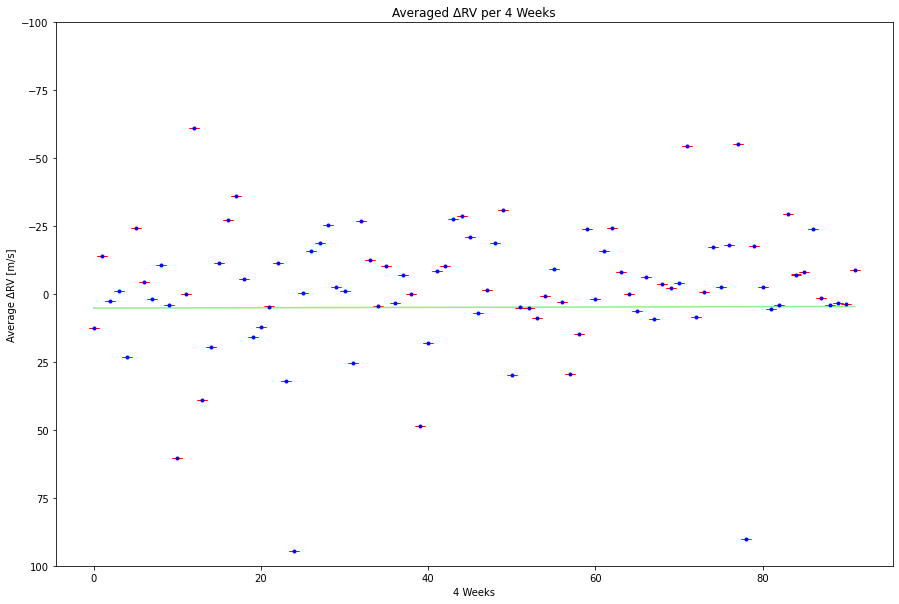

In [100]:
# Plot

x = np.arange(0,92)
y = avg_4weeks
yerr = avg_4weeks_w # 1/σ^2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('4 Weeks')
plt.ylabel('Average ΔRV [m/s]')
plt.title('Averaged ΔRV per 4 Weeks')
plt.ylim(100, -100)
print(a)
print(b)

mu: -0.1987497745755401 std: 69.64674352762326


(-200.0, 200.0)

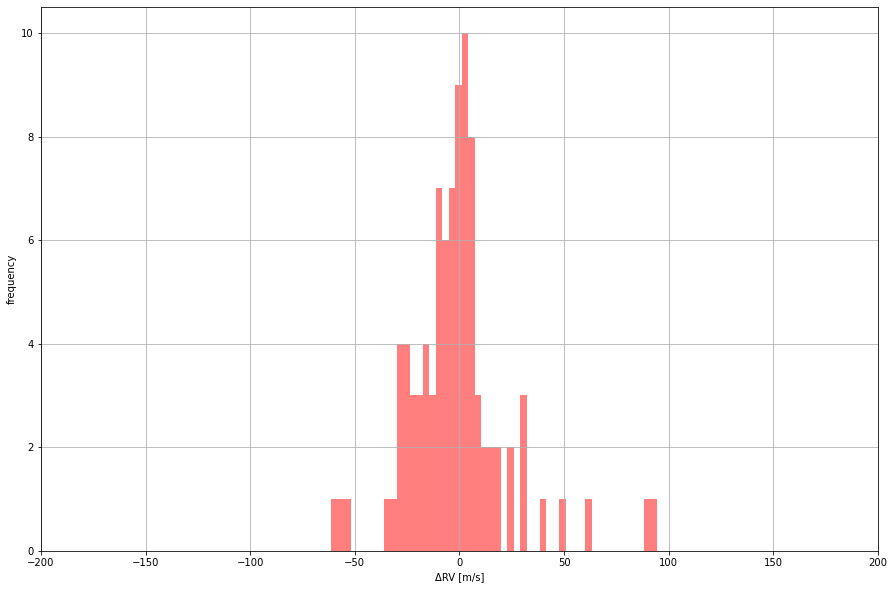

In [101]:
# Distribution of all combined ΔRVs

mua, stda = norm.fit(avg_weeks)

plt.figure(figsize=(15,10))
plt.hist(x=avg_4weeks, bins=50, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
#plt.title('Normalised weighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
plt.xlim(-200, 200)

## Plot ΔRVs per 30 days
1. Calculation of error

In [102]:
max(list(weightedavg_df_cutoff['Months']))

85.13333333333333

In [103]:
n = 0
p = 1
avg_30d = []
avg_30derr = []
avg_30d_w = []
for i in range(0, 86):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Months'] >= n) & (weightedavg_df_cutoff['Months'] < p)]
    print(period)
    weight = len(period['Months'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight
        avg_30d.append(avg)
        avg_30derr.append(1/avg_err)
        std = np.array(period['Combined ΔRV (m/s)']).std()
        w = 1/(std**2)
        avg_30d_w.append(w)
    else:
        avg_30d.append(0)
        avg_30derr.append(0)
        avg_30d_w.append(0)
    n = n+1
    p = p+1

          MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std     weight  \
32    55821.0          -13.579830            0.405298  0.299451  11.151876   
33    55824.0          109.909214            0.396504  0.346082   8.349146   
103   55815.0          -89.269265            0.899293  0.495835   4.067488   
104   55822.0           52.278622            0.318207  0.406197   6.060744   
158   55823.0           26.658330            0.356463  0.368797   7.352322   
406   55816.0         -139.924385            0.872246  0.520861   3.686014   
541   55825.0           55.673651            0.619179  0.278418  12.900469   
1403  55818.0          -39.974684            0.794723  0.441225   5.136640   
1418  55810.0          -22.480707            1.112503  0.286150  12.212697   
1419  55811.0           27.909765            0.416266  0.316662   9.972602   
1470  55813.0          -46.655512            0.534396  0.323182   9.574243   
1487  55807.0           29.848386           20.285959  0.642119 

          MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std     weight  \
58    56173.0          108.437971            0.271290  0.343053   8.497236   
152   56171.0          -40.171609            0.265828  0.353611   7.997414   
153   56177.0          -26.103042            0.385127  0.272947  13.422833   
155   56172.0           58.045724            0.225913  0.342902   8.504733   
162   56170.0         -440.964379            0.125268  0.354999   7.934957   
163   56175.0           40.465032            0.671837  0.294563  11.525096   
167   56169.0           -0.037678            0.249774  0.310513  10.371486   
196   56168.0            7.508220            0.335378  0.392575   6.488667   
393   56164.0          -66.084060            0.310647  0.295055  11.486697   
394   56165.0          128.583165            0.731100  0.342743   8.512628   
476   56174.0          119.863275            0.541017  0.426673   5.492994   
538   56176.0           40.665561            0.779448  0.292789 

998        0  2016-01-15T00:00:00Z  228.285714  57.071429  53.266667  
          MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std     weight  \
305   57446.0           76.926213            1.735567  0.472413   4.480799   
430   57447.0          -58.742546            1.863845  0.532185   3.530813   
436   57424.0           10.781756            0.408906  0.154268  42.019264   
437   57425.0           13.074759            0.350098  0.166450  36.093984   
438   57426.0            0.979241            0.480973  0.218757  20.896597   
439   57427.0           18.106615            0.415891  0.171309  34.075467   
488   57449.0           49.569003            2.858819  0.575968   3.014413   
512   57428.0            1.547896            0.367117  0.137584  52.827685   
513   57429.0           -0.522136            0.376617  0.181208  30.454224   
514   57430.0            5.751065            0.373604  0.183763  29.613158   
515   57431.0            7.293195            0.394418  0.131029  58.246

866        0  2016-12-24T00:00:00Z  277.428571  69.357143  64.733333  
          MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std      weight  \
85    57760.0          207.146981            0.215258  0.377394    7.021174   
199   57761.0           -6.420063            0.288167  0.356351    7.874875   
339   57765.0          -20.827854            0.603318  0.526534    3.607012   
344   57762.0            8.964829            0.638277  0.493200    4.111057   
346   57766.0         -135.408191            6.329709  0.774179    1.668467   
349   57764.0           50.185155            0.840507  0.560746    3.180293   
382   57776.0          -53.471078            1.106074  0.329282    9.222798   
383   57778.0         -100.331073            1.430690  0.394427    6.427850   
384   57779.0            0.154197            0.522891  0.227307   19.354099   
385   57780.0          -15.236746            0.532362  0.245296   16.619585   
388   57782.0            2.334659            0.360674  0.083

In [104]:
#avg_30d

In [105]:
#avg_4weeks

In [106]:
data_30d = [avg_30d, avg_30derr, list(range(0,86))]
df30d = pd.DataFrame(data_30d).transpose()
df30d.columns = ['Combined ΔRV (m/s)', 'Combined σRV (m/s)', '30 days']

0.0984578364472153
-1.8985966495637852


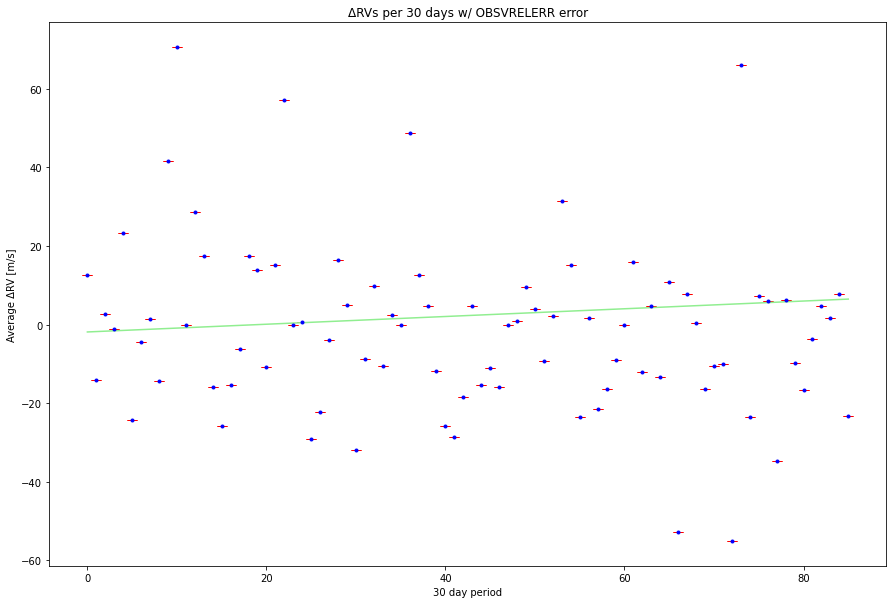

In [107]:
x = np.arange(0,86)
y = avg_30d
yerr = avg_30d_w
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days w/ OBSVRELERR error')
#plt.title('ΔRVs per 30 days w/ std error')
print(a)
print(b)

In [108]:
weightedavg_df_cutoff

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std       weight  \
0     58022.0           -8.053015            0.407374  0.320451     9.738178   
1     57743.0            0.023227            2.212728  0.027177  1353.921542   
2     56933.0            9.254238            0.147462  0.192564    26.967954   
3     56936.0           23.920864            0.095845  0.257771    15.049881   
4     56971.0         -178.377692            0.062524  0.258691    14.943034   
...       ...                 ...                 ...       ...          ...   
1519  55870.0          -73.029691            0.946294  0.348151     8.250209   
1520  56617.0           62.421917            1.511150  0.432546     5.344839   
1521  56625.0           11.459281            0.557512  0.309172    10.461668   
1522  56576.0           58.248624            0.569609  0.247437    16.333159   
1523  56482.0          305.706376            0.724491  0.387252     6.668252   

      Cluster                   ISO       Weeks    4 Weeks     Months  
0           0  2017-09-26T00:00:00Z  316.857143  79.214286  73.933333  
1           1  2016-12-21T00:00:00Z  277.000000  69.250000  64.633333  
2           0  2014-10-03T00:00:00Z  161.285714  40.321429  37.633333  
3           0  2014-10-06T00:00:00Z  161.714286  40.428571  37.733333  
4           0  2014-11-10T00:00:00Z  166.714286  41.678571  38.900000  
...       ...                   ...         ...        ...        ...  
1519        0  2011-11-05T00:00:00Z    9.428571   2.357143   2.200000  
1520        0  2013-11-21T00:00:00Z  116.142857  29.035714  27.100000  
1521        0  2013-11-29T00:00:00Z  117.285714  29.321429  27.366667  
1522        0  2013-10-11T00:00:00Z  110.285714  27.571429  25.733333  
1523        1  2013-07-09T00:00:00Z   96.857143  24.214286  22.600000  

[1524 rows x 10 columns]

In [109]:
df30d.sort_values('Combined ΔRV (m/s)', ascending=False)

Combined ΔRV (m/s)  Combined σRV (m/s)  30 days
10           70.710266            2.444166     10.0
73           66.208848            3.559168     73.0
22           57.264065            3.025099     22.0
36           48.664008            3.092997     36.0
9            41.614014            2.775494      9.0
..                 ...                 ...      ...
25          -29.120987            3.460738     25.0
30          -31.895297            3.334700     30.0
77          -34.800203            3.204426     77.0
66          -52.775956            2.849184     66.0
72          -55.169518            3.162548     72.0

[86 rows x 3 columns]

In [110]:
#df30d.loc[(df30d['Combined ΔRV (m/s)'] >= -10) & (df30d['Combined ΔRV (m/s)'] < 10)]

In [111]:
outlier1_df = df_cut.loc[(df_cut['Months'] >= 24) & (df_cut['Months'] < 25)]
outlier1 = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Months'] >= 24) & (weightedavg_df_cutoff['Months'] < 25)]

In [112]:
outlier1

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std      weight  \
55    56527.0           -0.381556            2.471352  0.047138  450.046618   
79    56541.0          -45.674584            0.294438  0.333132    9.010896   
255   56534.0            0.193084            0.005507  0.361313    7.660068   
397   56535.0            1.596103            0.272411  0.358669    7.773423   
398   56536.0           44.306052            0.323282  0.397452    6.330401   
399   56539.0          -12.694736            0.225414  0.371359    7.251229   
402   56542.0          138.147373            1.524228  0.463581    4.653170   
473   56540.0           46.079386            0.409504  0.305332   10.726424   
564   56543.0           47.773917            0.349045  0.290082   11.883895   
565   56544.0          -36.417835            0.418746  0.290359   11.861254   
625   56550.0         -172.609051            1.001908  0.242228   17.043228   
1445  56537.0           -2.803925            0.556302  0.338613    8.721533   

      Cluster                   ISO       Weeks    4 Weeks     Months  
55          1  2013-08-23T00:00:00Z  103.285714  25.821429  24.100000  
79          0  2013-09-06T00:00:00Z  105.285714  26.321429  24.566667  
255         0  2013-08-30T00:00:00Z  104.285714  26.071429  24.333333  
397         0  2013-08-31T00:00:00Z  104.428571  26.107143  24.366667  
398         0  2013-09-01T00:00:00Z  104.571429  26.142857  24.400000  
399         0  2013-09-04T00:00:00Z  105.000000  26.250000  24.500000  
402         1  2013-09-07T00:00:00Z  105.428571  26.357143  24.600000  
473         0  2013-09-05T00:00:00Z  105.142857  26.285714  24.533333  
564         0  2013-09-08T00:00:00Z  105.571429  26.392857  24.633333  
565         0  2013-09-09T00:00:00Z  105.714286  26.428571  24.666667  
625         0  2013-09-15T00:00:00Z  106.571429  26.642857  24.866667  
1445        0  2013-09-02T00:00:00Z  104.714286  26.178571  24.433333

In [113]:
sum(outlier1['Combined ΔRV (m/s)']) / len(outlier1['Combined ΔRV (m/s)'])

0.6261858043533564

Text(0, 0.5, 'Frequency')

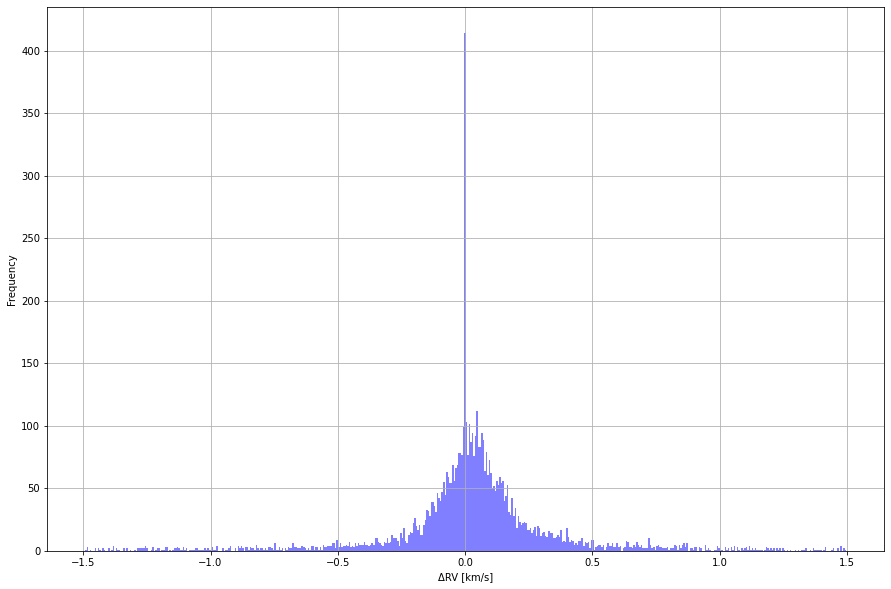

In [114]:
plt.figure(figsize=(15, 10))
#plt.hist(x=outlier1['ΔRV'], bins=10, alpha=0.5, color='r')
plt.hist(x=outlier1_df['ΔRV'], bins=500, alpha=0.5, color='b')
plt.grid()
plt.xlabel('ΔRV [km/s]')
plt.ylabel('Frequency')
#plt.xlim(-0.2, 0.2)

In [115]:
weightedavg_df_cutoff.sort_values('Combined ΔRV (m/s)')

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std      weight  \
616   57795.0        -1103.852069            0.352735  0.515192    3.767578   
527   57050.0        -1090.159679            0.014915  0.286857   12.152600   
658   58140.0         -744.220229           54.963821  0.070079  203.621368   
646   56707.0         -509.795698            0.225968  0.312961   10.209845   
162   56170.0         -440.964379            0.125268  0.354999    7.934957   
...       ...                 ...                 ...       ...         ...   
1523  56482.0          305.706376            0.724491  0.387252    6.668252   
366   57409.0          341.656940            0.511530  0.522980    3.656205   
573   57705.0          384.895401            0.719553  0.270515   13.665265   
482   56673.0          385.209036            0.185154  0.303604   10.848872   
1429  57997.0         1108.639519           55.122140  0.000000    0.000000   

      Cluster                   ISO       Weeks    4 Weeks     Months  
616         1  2017-02-11T00:00:00Z  284.428571  71.107143  66.366667  
527         1  2015-01-28T00:00:00Z  178.000000  44.500000  41.533333  
658         1  2018-01-22T00:00:00Z  333.714286  83.428571  77.866667  
646         1  2014-02-19T00:00:00Z  129.000000  32.250000  30.100000  
162         1  2012-08-31T00:00:00Z   52.285714  13.071429  12.200000  
...       ...                   ...         ...        ...        ...  
1523        1  2013-07-09T00:00:00Z   96.857143  24.214286  22.600000  
366         1  2016-01-22T00:00:00Z  229.285714  57.321429  53.500000  
573         1  2016-11-13T00:00:00Z  271.571429  67.892857  63.366667  
482         1  2014-01-16T00:00:00Z  124.142857  31.035714  28.966667  
1429        1  2017-09-01T00:00:00Z  313.285714  78.321429  73.100000  

[1524 rows x 10 columns]

## Cut ΔRV values |1000 m/s|

In [116]:
weighted_cut = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Combined ΔRV (m/s)'] >= -1000) & (weightedavg_df_cutoff['Combined ΔRV (m/s)'] < 1000)]

In [117]:
weighted_cut.sort_values('Combined ΔRV (m/s)')

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std      weight  \
658   58140.0         -744.220229           54.963821  0.070079  203.621368   
646   56707.0         -509.795698            0.225968  0.312961   10.209845   
162   56170.0         -440.964379            0.125268  0.354999    7.934957   
1374  57880.0         -412.599158            0.644058  0.207930   23.129442   
649   56772.0         -368.990265            0.053932  0.260281   14.761032   
...       ...                 ...                 ...       ...         ...   
1509  56479.0          305.494082            1.111848  0.449166    4.956627   
1523  56482.0          305.706376            0.724491  0.387252    6.668252   
366   57409.0          341.656940            0.511530  0.522980    3.656205   
573   57705.0          384.895401            0.719553  0.270515   13.665265   
482   56673.0          385.209036            0.185154  0.303604   10.848872   

      Cluster                   ISO       Weeks    4 Weeks     Months  
658         1  2018-01-22T00:00:00Z  333.714286  83.428571  77.866667  
646         1  2014-02-19T00:00:00Z  129.000000  32.250000  30.100000  
162         1  2012-08-31T00:00:00Z   52.285714  13.071429  12.200000  
1374        1  2017-05-07T00:00:00Z  296.571429  74.142857  69.200000  
649         1  2014-04-25T00:00:00Z  138.285714  34.571429  32.266667  
...       ...                   ...         ...        ...        ...  
1509        1  2013-07-06T00:00:00Z   96.428571  24.107143  22.500000  
1523        1  2013-07-09T00:00:00Z   96.857143  24.214286  22.600000  
366         1  2016-01-22T00:00:00Z  229.285714  57.321429  53.500000  
573         1  2016-11-13T00:00:00Z  271.571429  67.892857  63.366667  
482         1  2014-01-16T00:00:00Z  124.142857  31.035714  28.966667  

[1521 rows x 10 columns]

## 30 day ΔRVs w/ cut

In [118]:
# Calculate ΔRV values per 30 days

n = 0
p = 1
avg_30d2 = []
avg_30derr2 = []
avg_30dstd = []
avg_30d_w2 = []
for i in range(0, 86):
    period = weighted_cut.loc[(weighted_cut['Months'] >= n) & (weighted_cut['Months'] < p)]
    #print(period)
    weight = len(period['Months'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_30d2.append(avg)
        avg_30derr2.append(1/avg_err)
        std = np.array(period['Combined ΔRV (m/s)']).std()/2
        w = 1/(std**2)
        avg_30d_w2.append(w)
        avg_30dstd.append(std)
    #else:
        #avg_30d2.append(0)
        #avg_30derr2.append(0)
        #avg_30d_w2.append(0)
        #avg_30dstd.append(0)
    n = n+1
    p = p+1
print(len(avg_30d_w2))

81


In [119]:
avg_30dstd

[42.787361357628996,
 27.048008851816597,
 32.05104671396734,
 10.825130352765427,
 27.57886916624383,
 35.1641936956312,
 22.251554364682875,
 12.435278627117233,
 25.753029677139242,
 64.09128390301494,
 39.137592003073166,
 74.16175746582353,
 21.208441745625887,
 26.211828457557612,
 20.5431409263832,
 28.797592483910776,
 20.39577754257248,
 16.737944293164244,
 18.275991058717572,
 14.80105647070924,
 22.251141860381743,
 66.32386824114916,
 35.00795568089954,
 31.746851981949572,
 33.28410363845084,
 20.39265414880389,
 45.60742101477263,
 17.508489172826316,
 55.5584669161182,
 26.406506118413745,
 46.900207649375744,
 40.979740135316405,
 10.064851372490274,
 36.020800225026285,
 19.201410797867396,
 37.763452331786944,
 14.619906135125971,
 23.247251545712878,
 30.17444469112002,
 18.409030369545498,
 16.23439303197309,
 32.075962434503495,
 46.3553876639952,
 29.977148321450183,
 17.20522254332235,
 10.00901934742066,
 10.990334015221235,
 17.25968958341402,
 10.826956321298

a= 0.1040542656085063
b= -1.847834726942623


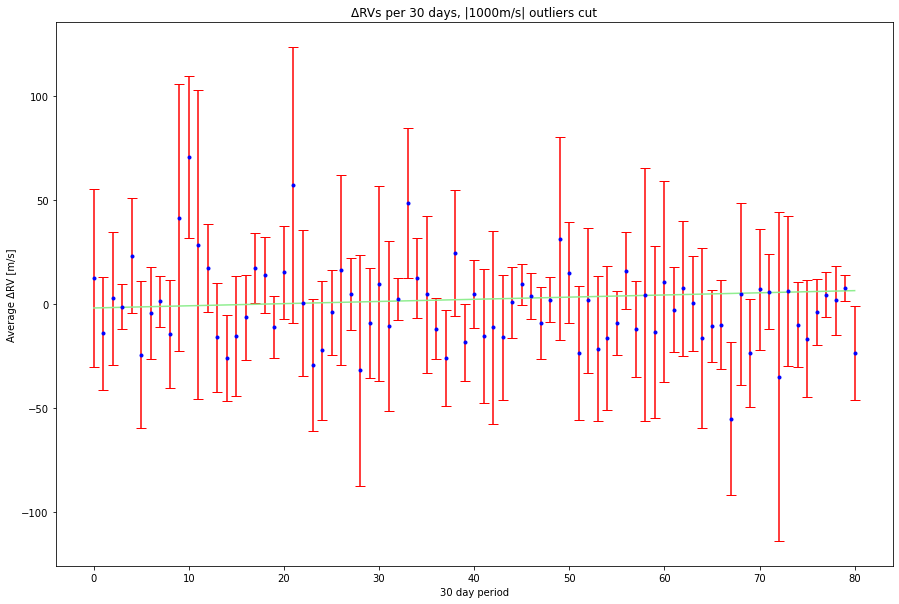

In [120]:
# Plot ΔRV values per 30 days and get slope + intercept

x = np.arange(0,81)
y = avg_30d2
yerr = avg_30dstd
weight = avg_30d_w2
a, b = np.polyfit(x, y, 1, w=weight)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days, |1000m/s| outliers cut')
print('a=', a)
print('b=', b)

a= 0.1040542656085063
b= -1.847834726942623


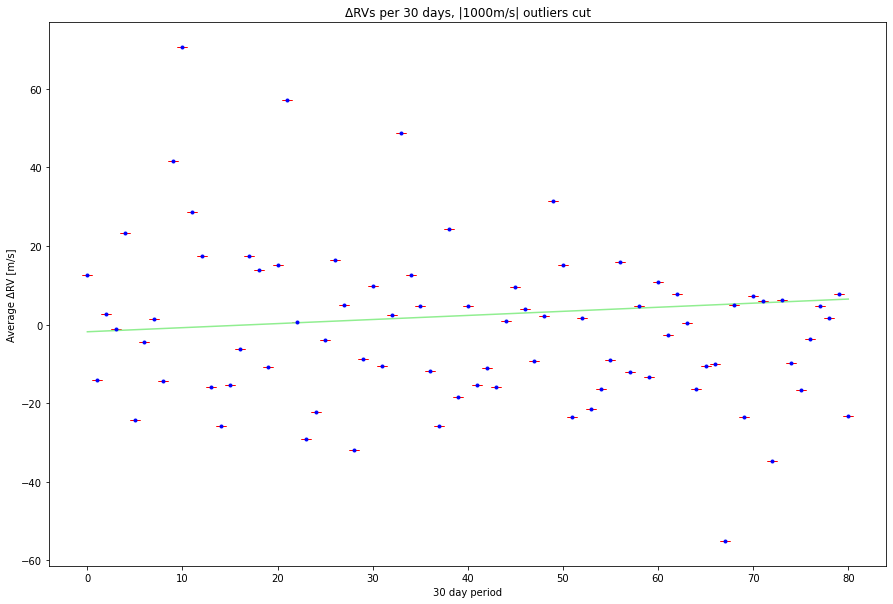

In [121]:
# Plot ΔRV values per 30 days and get slope + intercept

x = np.arange(0,81)
y = avg_30d2
yerr = avg_30dstd
weight = avg_30d_w2
a, b = np.polyfit(x, y, 1, w=weight)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, weight, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days, |1000m/s| outliers cut')
print('a=', a)
print('b=', b)

In [122]:
# 30 day binning
n = 81
_b = -1.847834726942623
_a = 0.1040542656085063
_sigma = avg_30dstd #20.10334754313373
x = np.linspace(0, 80, 81)
y = _a*x + _b
yobs = avg_30d2

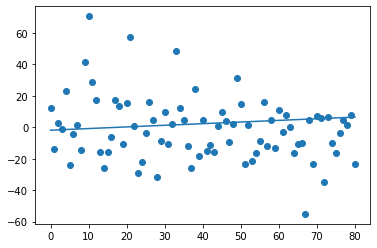

In [123]:
plt.scatter(x, yobs)
plt.plot(x, y)

In [124]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    qs = np.sqrt(sigma**2 + np.array(avg_30d_w2)**2)
    
    likelihood = pm.Normal('y', mu=b+a*x, tau=qs, observed=yobs)
    
    trace30d = pm.sample(10000, cores=16, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, b, a]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 125 seconds.
The acceptance probability does not match the target. It is 0.8786355292961003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788125164479925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844159880219561, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

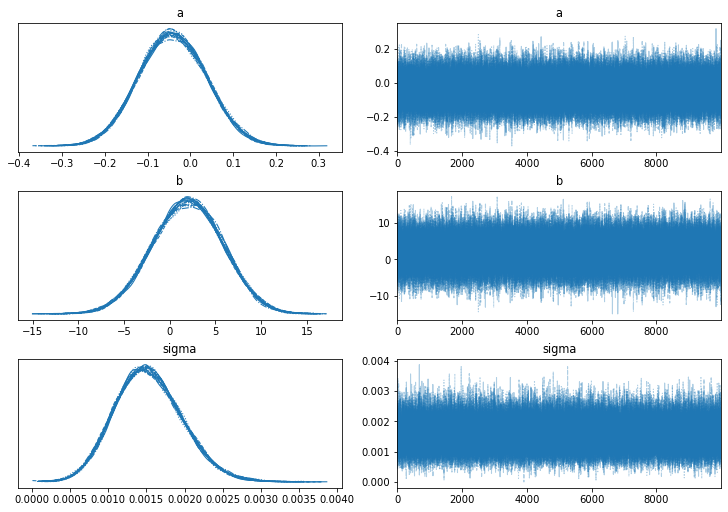

In [126]:
az.plot_trace(trace30d, figsize=(10, 7))

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

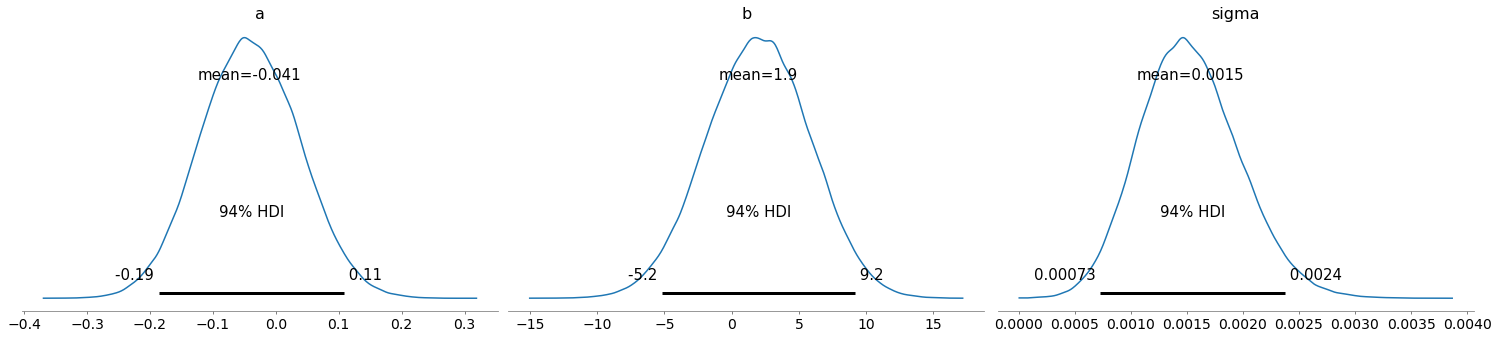

In [127]:
pm.plot_posterior(trace30d)

In [128]:
pm.summary(trace30d)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.041  0.078  -0.186    0.108      0.000    0.000   63800.0   74442.0   
b      1.938  3.839  -5.184    9.187      0.015    0.011   64386.0   75523.0   
sigma  0.002  0.000   0.001    0.002      0.000    0.000   76486.0   60355.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

In [229]:
"""
MCMC STEPS

- Use 30 day binning data instead of random generated data
- uniform prior distribution -> non-informative prior, so equal likelihood of any point?

1. Define data set
size = # of data points
x = bins
ytrue = a*x + b?
y = a*x + b + yerr
yerr = std of ΔRVs --> recalculate?

2. Define MCMC model: uniform prior
- how to pick sigma + mu??? from 30 day binning data set?

3. Run the model to get traces of a, b, yerr?

"""

'\nMCMC STEPS\n\n- Use 30 day binning data instead of random generated data\n- uniform prior distribution -> non-informative prior, so equal likelihood of any point?\n\n1. Define data set\nsize = # of data points\nx = bins\nytrue = a*x + b?\ny = a*x + b + yerr\nyerr = std of ΔRVs --> recalculate?\n\n2. Define MCMC model: uniform prior\n- how to pick sigma + mu??? from 30 day binning data set?\n\n3. Run the model to get traces of a, b, yerr?\n\n'

In [189]:
# Get ΔRV data for 4 random 30 day bins 

#bin_mo4 = weighted_cut.loc[(weighted_cut['Months'] >= 4) & (weighted_cut['Months'] < 5)]
#bin_mo15 = weighted_cut.loc[(weighted_cut['Months'] >= 15) & (weighted_cut['Months'] < 16)]
#bin_mo42 = weighted_cut.loc[(weighted_cut['Months'] >= 42) & (weighted_cut['Months'] < 43)]
#bin_mo68 = weighted_cut.loc[(weighted_cut['Months'] >= 68) & (weighted_cut['Months'] < 69)]

bin_mo4 = df_cut.loc[(df_cut['Months'] >= 4) & (df_cut['Months'] < 5)]
bin_mo15 = df_cut.loc[(df_cut['Months'] >= 15) & (df_cut['Months'] < 16)]
bin_mo42 = df_cut.loc[(df_cut['Months'] >= 42) & (df_cut['Months'] < 43)]
bin_mo68 = df_cut.loc[(df_cut['Months'] >= 68) & (df_cut['Months'] < 69)]

mu: -0.012755433279765754 std: 0.44205826916427615


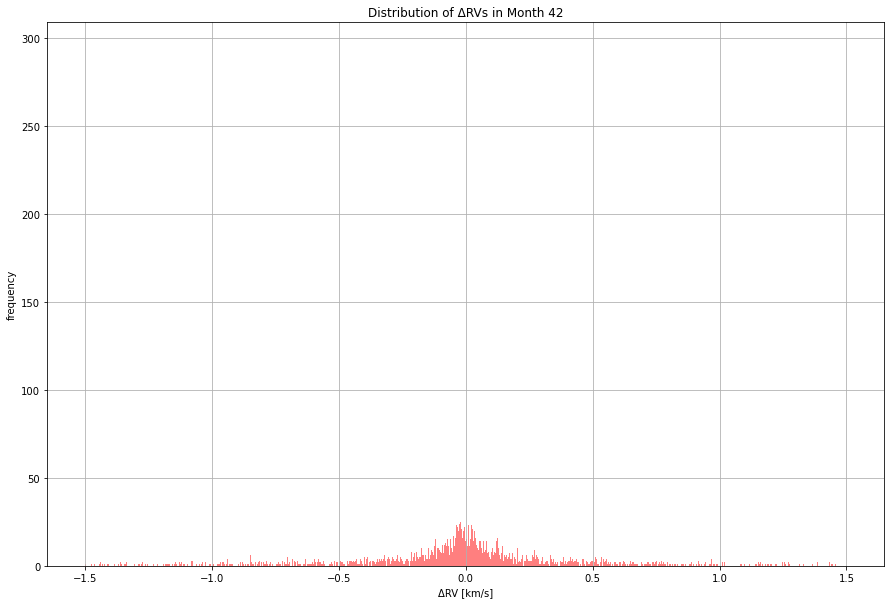

In [196]:
x_mo42 = bin_mo42['ΔRV'] #['Combined ΔRV (m/s)']
mu_mo42, std_mo42 = norm.fit(x_mo42)

plt.figure(figsize=(15,10))
plt.hist(x=x_mo42, bins=5000, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Distribution of ΔRVs in Month 42')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu_mo42, 'std:', std_mo42)
#plt.xlim(-0.02, 0.02)

In [178]:
bin_mo15['Weeks'].sort_values(ascending=True)

317596     64.285714
1714014    64.285714
362037     64.285714
27805      64.285714
362075     64.285714
             ...    
83236      68.428571
83264      68.428571
83290      68.428571
83294      68.428571
173472     68.428571
Name: Weeks, Length: 24158, dtype: float64

In [197]:
# Get ΔRV data for 4 random 4 week bins 

#bin_mo4 = weighted_cut.loc[(weighted_cut['Months'] >= 4) & (weighted_cut['Months'] < 5)]
#bin_mo15 = weighted_cut.loc[(weighted_cut['Months'] >= 15) & (weighted_cut['Months'] < 16)]
#bin_mo42 = weighted_cut.loc[(weighted_cut['Months'] >= 42) & (weighted_cut['Months'] < 43)]
#bin_mo68 = weighted_cut.loc[(weighted_cut['Months'] >= 68) & (weighted_cut['Months'] < 69)]

bin_mo4w = df_cut.loc[(df_cut['Weeks'] >= 17) & (df_cut['Weeks'] < 20)]
bin_mo15w = df_cut.loc[(df_cut['Weeks'] >= 64) & (df_cut['Weeks'] < 68)]
bin_mo42w = df_cut.loc[(df_cut['Weeks'] >= 180) & (df_cut['Weeks'] < 185)]
bin_mo68w = df_cut.loc[(df_cut['Weeks'] >= 291) & (df_cut['Weeks'] < 295)]

mu: -0.008818024941908647 std: 0.43316414850957013


(-0.02, 0.02)

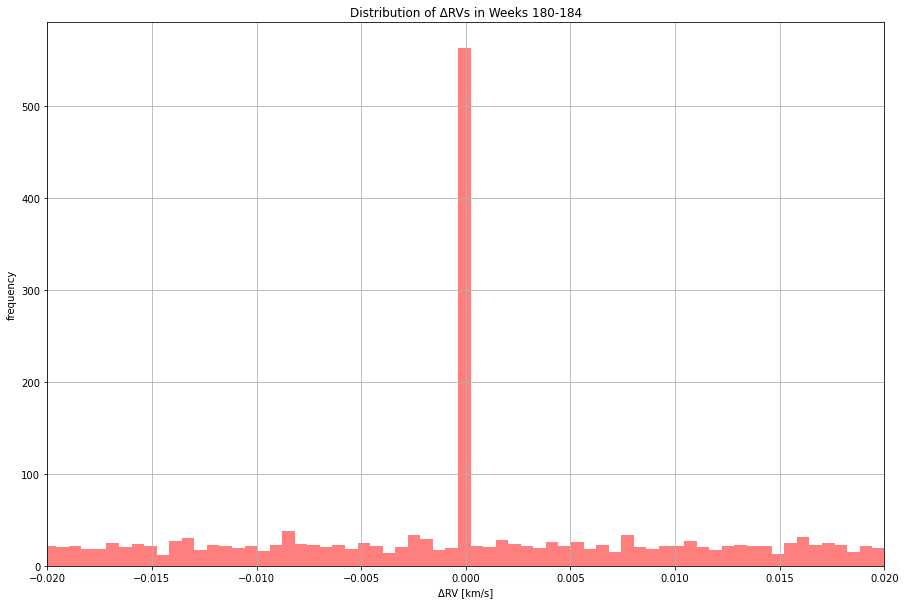

In [199]:
x_mo42w = bin_mo42w['ΔRV'] #['Combined ΔRV (m/s)']
mu_mo42w, std_mo42w = norm.fit(x_mo42w)

plt.figure(figsize=(15,10))
plt.hist(x=x_mo42w, bins=5000, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Distribution of ΔRVs in Weeks 180-184')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu_mo42w, 'std:', std_mo42w)
plt.xlim(-0.02, 0.02)

mu: 0.11085356764340477 std: 0.5151917147598559


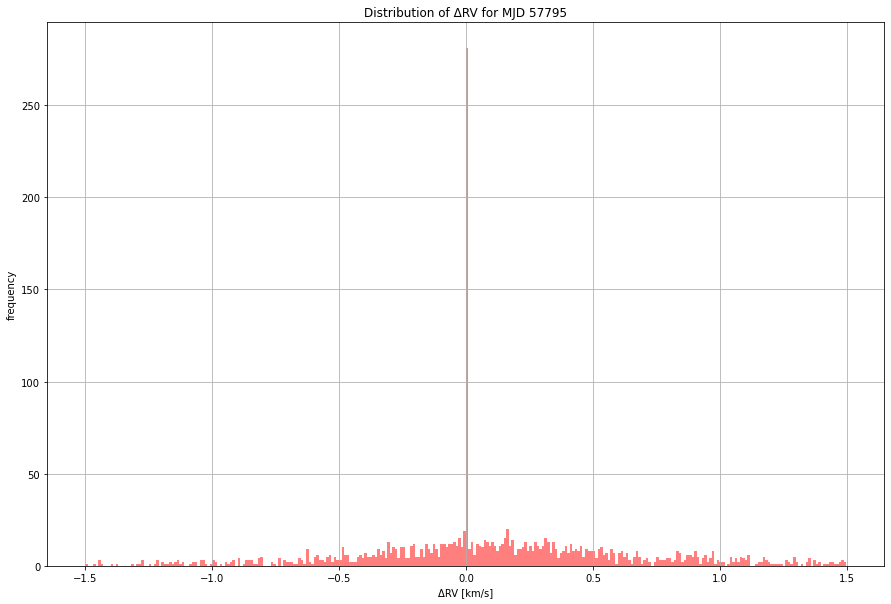

In [134]:
x_57795 = df_cut[df_cut['MJD'] == 57795.0]['ΔRV']
mu_57795, std_57795 = norm.fit(x_57795)

plt.figure(figsize=(15,10))
plt.hist(x=x_57795, bins=300, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Distribution of ΔRV for MJD 57795') # Point which had combined ΔRV of ~ -1000 m/s
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu_57795, 'std:', std_57795)
#plt.xlim(-200, 200)

In [175]:
df_cut.loc[(df_cut['Weeks'] >= 16) & (df_cut['Weeks'] < 17)]



Empty DataFrame
Columns: [Target ID, Plate ID, MJD, OBSVHELIO (km/s), OBSVREL Error (km/s), <RV>, ΔRV, Cluster, ISO, Weeks, Months]
Index: []

In [164]:
bin_mo68

Target ID      Plate ID    MJD  \
557494   apo25m.2418.193+29_MGA.2M08033109+2843110          9504  57862   
557495   apo25m.2418.193+29_MGA.2M08033109+2843110          9504  57863   
557534   apo25m.2418.193+29_MGA.2M08033291+2853334          9504  57862   
557535   apo25m.2418.193+29_MGA.2M08033291+2853334          9504  57863   
557569   apo25m.2418.193+29_MGA.2M08033384+2901598          9504  57862   
...                                            ...           ...    ...   
1531131      apo25m.5193.064+06.2M19353469+3027140          9307  57862   
1531332      apo25m.5193.064+06.2M19354285+2956182          9306  57860   
1531371      apo25m.5193.064+06.2M19354322+3018582          9306  57860   
1531374      apo25m.5193.064+06.2M19354322+3018582          9307  57862   
1531523      apo25m.5193.064+06.2M19354765+3028423          9306  57860   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)       <RV>       ΔRV  Cluster  \
557494           7.351900              0.039213   7.213333  0.138567        0   
557495           7.311180              0.039269   7.213333  0.097847        0   
557534         -15.612805              0.025801 -15.594288 -0.018517        0   
557535         -15.729817              0.025683 -15.594288 -0.135529        0   
557569          18.293158              0.050053  18.077413  0.215744        0   
...                   ...                   ...        ...       ...      ...   
1531131         -0.671888              0.116911  -0.468575 -0.203313        0   
1531332          3.660828              0.044899   3.690546 -0.029719        0   
1531371        -84.742670              0.090403 -84.549478 -0.193190        0   
1531374        -84.740790              0.074143 -84.549478 -0.191313        0   
1531523        -29.974640              0.102840 -29.960321 -0.014319        0   

                          ISO       Weeks     Months  
557494   2017-04-19T00:00:00Z  294.000000  68.600000  
557495   2017-04-20T00:00:00Z  294.142857  68.633333  
557534   2017-04-19T00:00:00Z  294.000000  68.600000  
557535   2017-04-20T00:00:00Z  294.142857  68.633333  
557569   2017-04-19T00:00:00Z  294.000000  68.600000  
...                       ...         ...        ...  
1531131  2017-04-19T00:00:00Z  294.000000  68.600000  
1531332  2017-04-17T00:00:00Z  293.714286  68.533333  
1531371  2017-04-17T00:00:00Z  293.714286  68.533333  
1531374  2017-04-19T00:00:00Z  294.000000  68.600000  
1531523  2017-04-17T00:00:00Z  293.714286  68.533333  

[31785 rows x 11 columns]

In [79]:
import pymc3 as pm

In [80]:
# Observed data
X = avg_30d2

In [81]:
mu30d, std30d = norm.fit(avg_30d2)
print(mu30d)
print(std30d)

-0.8823301351959657
19.511428967299267


In [99]:
np.array(avg_30dstd).std()

31.962560318221946

In [103]:
#avg_30dstd

Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [mu]


Sampling 3 chains for 1_000 tune and 50_000 draw iterations (3_000 + 150_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2376/4230370737.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


<AxesSubplot:title={'center':'mu'}>

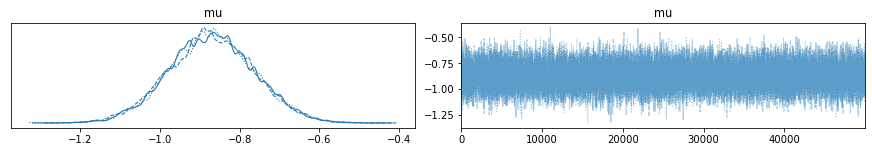

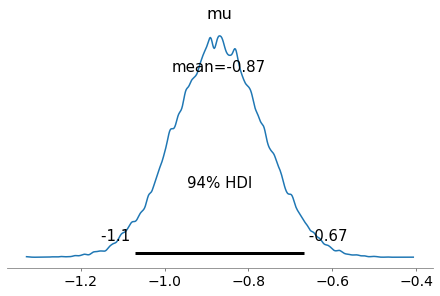

In [82]:
with pm.Model() as model:
    prior=pm.Normal('mu', mu=0, sigma=1) #prior
    obs = pm.Normal('obs', mu=prior, sigma=1, observed=X) #likelihood
    step = pm.Metropolis()
    
    # sample w/ 3 independent Markov chains?
    trace = pm.sample(draws=50000, chains=3, step=step, return_inferencedata=True)
    
pm.traceplot(trace)
pm.plot_posterior(trace)

Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [mu]


Sampling 3 chains for 1_000 tune and 50_000 draw iterations (3_000 + 150_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2376/630100587.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


<AxesSubplot:title={'center':'mu'}>

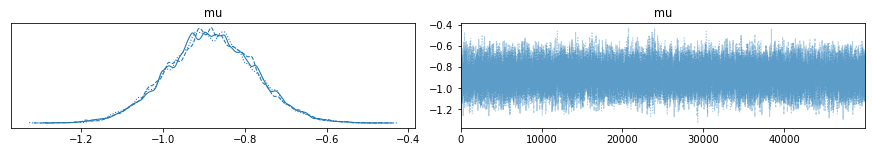

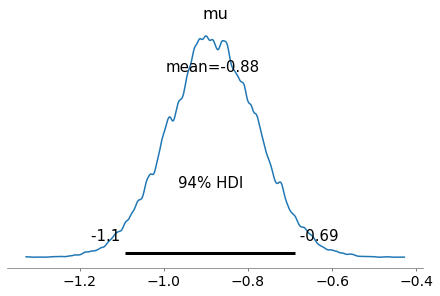

In [83]:
with pm.Model() as model:
    prior=pm.Normal('mu', mu=-0.8823301351959657, sigma=19.511428967299267) #prior
    obs = pm.Normal('obs', mu=prior, sigma=1, observed=X) #likelihood
    step = pm.Metropolis()
    
    # sample w/ 3 independent Markov chains?
    trace = pm.sample(draws=50000, chains=3, step=step, return_inferencedata=True)
    
pm.traceplot(trace)
pm.plot_posterior(trace)

In [84]:
n = 86
a = 20
b = 4
sigma = 2.5
#x = np.random.uniform(0, 1, n)
x = np.array(avg_30d2)
yerr = avg_30d_w2
y_obs = a*x + b + yerr
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])

<AxesSubplot:xlabel='x', ylabel='y'>

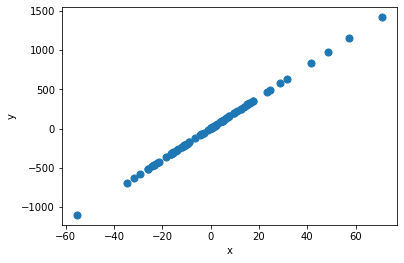

In [85]:
data.plot(x='x', y='y', kind='scatter', s=50)

Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [mu]


Sampling 3 chains for 1_000 tune and 50_000 draw iterations (3_000 + 150_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2376/934682419.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


<AxesSubplot:title={'center':'mu'}>

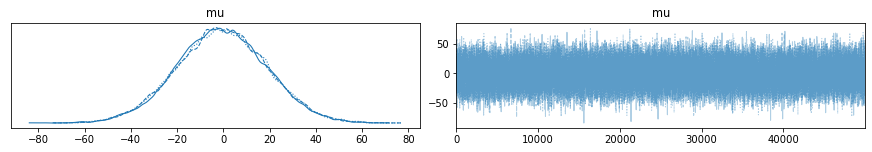

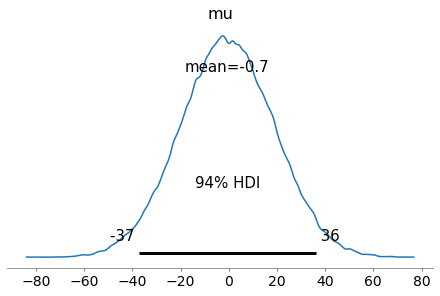

In [86]:
model = pm.Model()

with model:
    prior=pm.Normal('mu', mu=-0.8823301351959657, sigma=19.511428967299267) #prior
    #obs = pm.Normal('obs', mu=prior, sigma=1, observed=y_obs) #likelihood
    obs = pm.Normal('Y', mu=4 + 1 * x,sd=sigma, observed=y_obs)
    step = pm.Metropolis()
    
    # sample w/ 3 independent Markov chains?
    trace = pm.sample(draws=50000, chains=3, step=step, return_inferencedata=True)
    
pm.traceplot(trace)
pm.plot_posterior(trace)

In [87]:
pm.Normal('Y', mu=intercept + x_coeff * df['x'],sd=sigma, observed=df['y'])

NameError: name 'intercept' is not defined

In [ ]:
x = np.arange(0,86)
y = avg_30d2
yerr = avg_30d_w2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days, |1000m/s| outliers cut')
print(a)

In [ ]:
N_points = len(avg_30d2)
N_points

In [ ]:
x = np.array(avg_30d2)

In [ ]:
def f(x):
    return 0.3*x +2

In [ ]:
y = f(x)+avg_30d_w2
true_sigma_y = 

In [ ]:
mu_m = 0
mu_b = 0

sigma_m = 0.2
sigma_b = 0.2

In [ ]:
model = pm.Model()

with model:
    m = pm.Normal('m', mu=mu_m, sd=sigma_m)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b)
    
    prior_trace = pm.sample(200)

In [ ]:
pm.traceplot(prior_trace)
pm.plot_posterior(prior_trace)

In [ ]:
sigma_y = true_sigma_y

# Use the model defined above
with model:
    exp_f = m * x + b
    
    Y_obs = pm.Normal('Y_obs', mu=exp_f, sd=sigma_y, observed=Y)
    
    posterior_trace = pm.sample(200, tune=1000)

a= 0.1040542656085063
b= -1.847834726942623


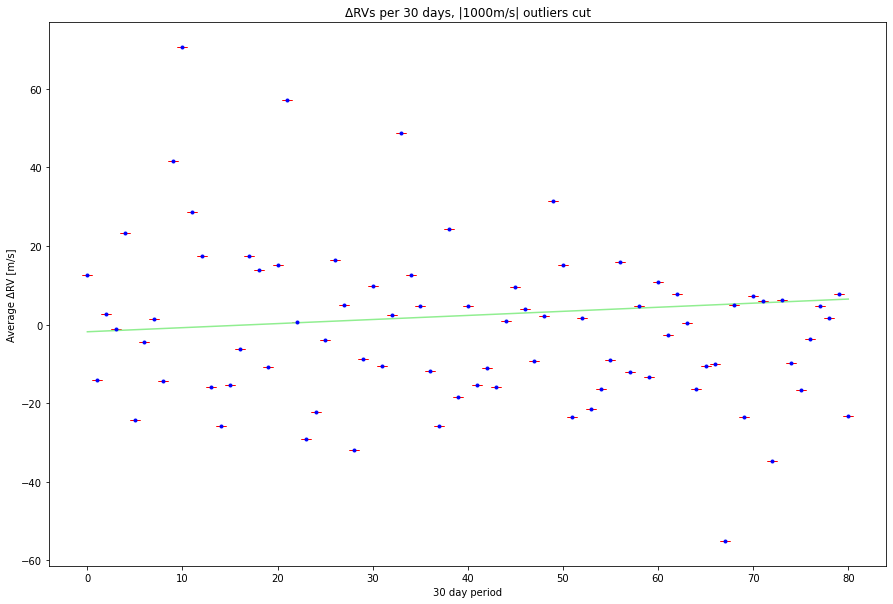

In [215]:
# Plot ΔRV values per 30 days and get slope + intercept

x = np.arange(0,81)
y = avg_30d2
yerr = avg_30d_w2
weight = avg_30d_w2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days, |1000m/s| outliers cut')
print('a=', a)
print('b=', b)

### 1 Week ΔRVs w/ cut

In [129]:
n = 0
p = 1
avg_7d2 = []
avg_7derr2 = []
avg_weeks_w2 = []
for i in range(0, 365):
    period = weighted_cut.loc[(weighted_cut['Weeks'] >= n) & (weighted_cut['Weeks'] < p)]
    #print(period)
    weight = len(period['Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_7d2.append(avg)
        std = np.array(period['Combined ΔRV (m/s)']).std()
        avg_7derr2.append(std)
        if std == 0:
            print(std)
            avg_weeks_w2.append(std)
        else:
            w = 1/std**2
            #print(w)
            avg_weeks_w2.append(w)    
    #else:
        #avg_7d2.append(0)
        #avg_7derr2.append(0)
        #avg_weeks_w2.append(0)
    n = n+1
    p = p+1

print(len(avg_7d2))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
307


slope= 0.011039173768061234
intercept= -0.9148459495318688


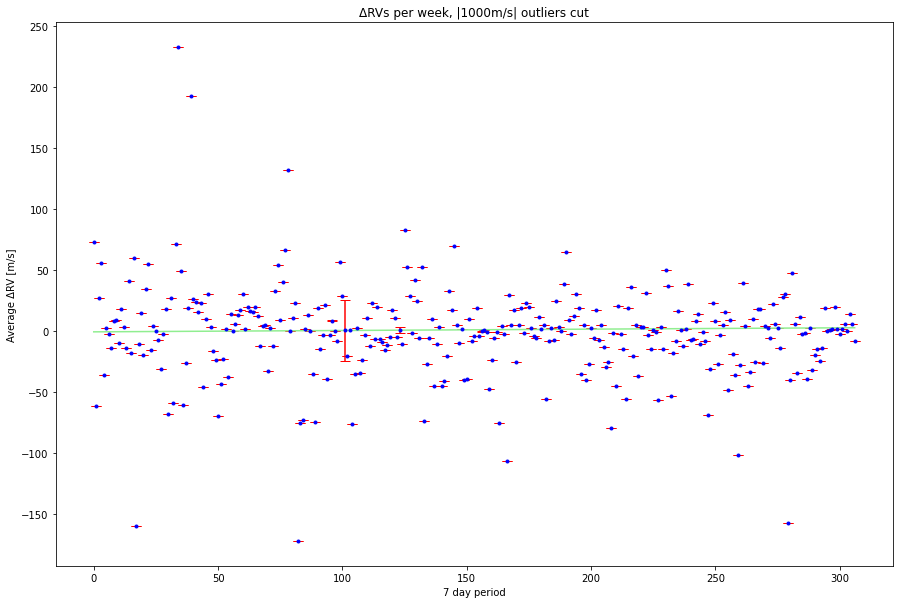

In [130]:
x = np.arange(0,307)
y = avg_7d2
yerr = avg_7derr2
weight = avg_weeks_w2
a, b = np.polyfit(x, y, 1, w=weight)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, weight, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('7 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per week, |1000m/s| outliers cut')
#plt.ylim(-15, 10)
print('slope=', a)
print('intercept=', b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, b, a]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 169 seconds.
The acceptance probability does not match the target. It is 0.8938371492474378, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943264530757282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067244026151451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9083120167881878, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793103997900155, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865891414393262, but should be close to 0.8. Try to increase the nu

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.010  0.008  -0.026    0.005      0.000    0.000   56495.0   61471.0   
b      1.403  0.897  -0.297    3.069      0.004    0.003   56588.0   62473.0   
sigma  0.000  0.000   0.000    0.000      0.000    0.000   77177.0   67496.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

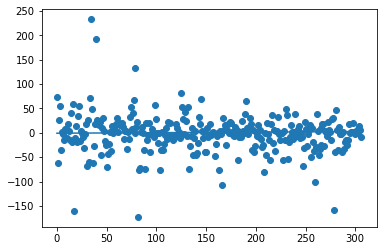

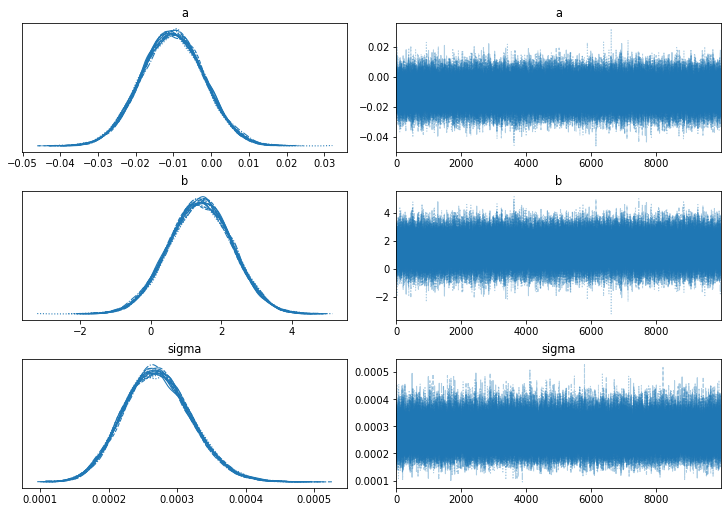

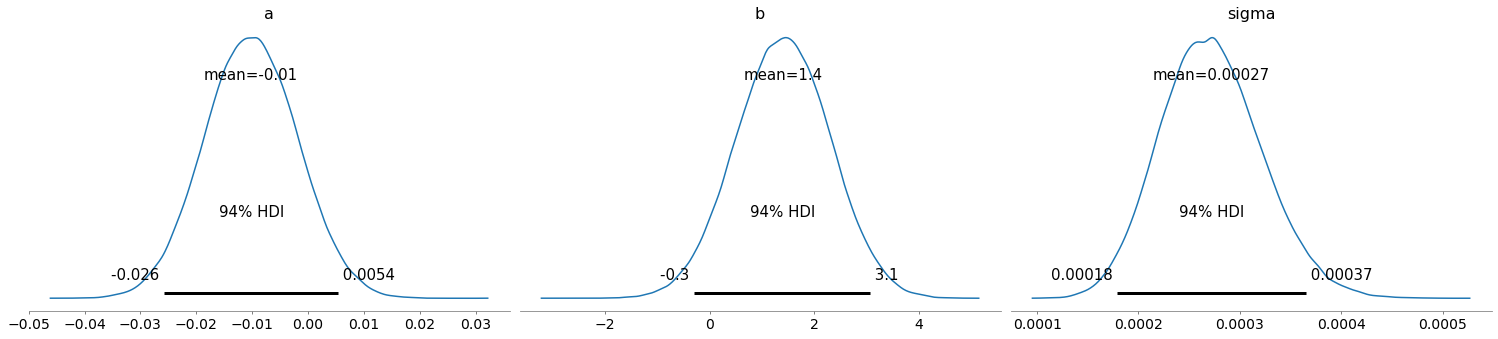

In [131]:
# 7 day binning
n = 307
_b = -0.9148459495318688 #5.2373371053304645
_a = 0.011039173768061234 #-0.04843860912504228
_sigma = avg_weeks_w2
x = np.linspace(0, 306, 307)
y = _a*x + _b
yobs = avg_7d2

plt.scatter(x, yobs)
plt.plot(x, y)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    qs = np.sqrt(sigma**2 + np.array(_sigma)**2)
    
    likelihood = pm.Normal('y', mu=b+a*x, tau=qs, observed=yobs)
    
    trace7d = pm.sample(10000, cores=16, return_inferencedata=True)

az.plot_trace(trace7d, figsize=(10, 7))
pm.plot_posterior(trace7d)

pm.summary(trace7d)

In [139]:
az.hdi(trace7d, hdi_prob=0.68)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    a        (hdi) float64 -0.01861 -0.002082
    b        (hdi) float64 0.5017 2.293
    sigma    (hdi) float64 0.0002178 0.0003167

In [138]:
az.hdi(trace7d, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    a        (hdi) float64 -0.02571 0.005368
    b        (hdi) float64 -0.2972 3.069
    sigma    (hdi) float64 0.0001789 0.0003655

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

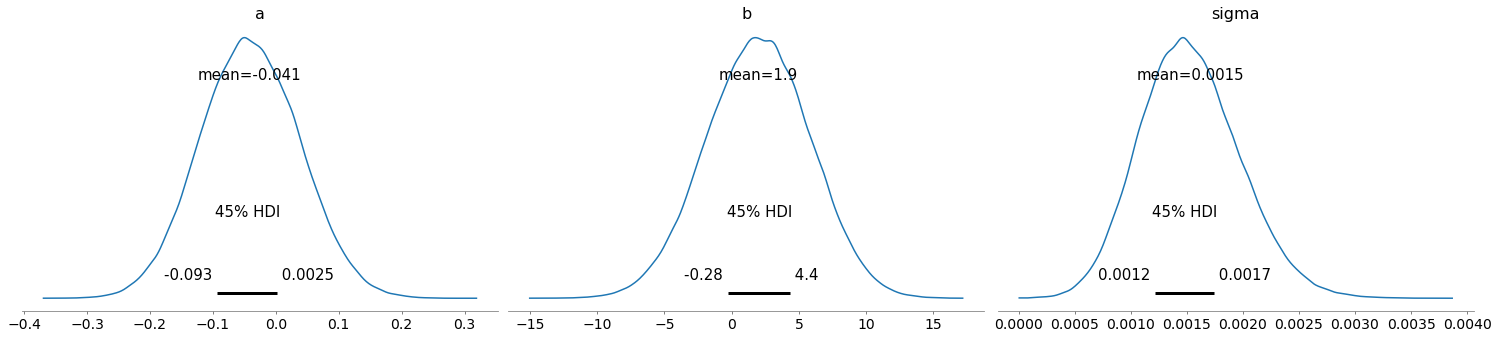

In [157]:
# Posterior plot for 30 day binning
pm.plot_posterior(trace30d, hdi_prob = 0.45)

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

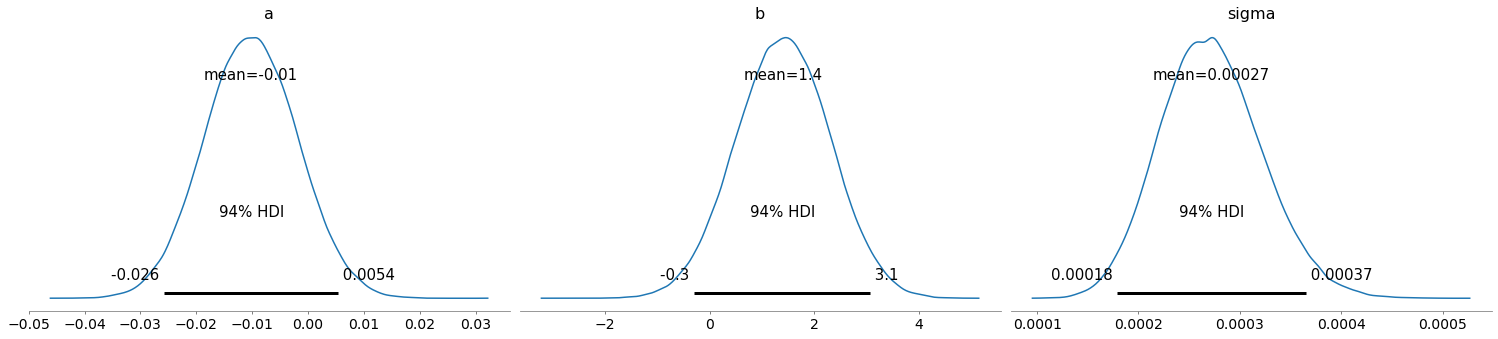

In [149]:
# Posterior plots for 7 day binning
pm.plot_posterior(trace7d, hdi_prob = 0.94)

### 4 Weeks ΔRVs w/ cut

In [132]:
# Calculate average per 4 weeks + average error per 4 weeks

n = 0
p = 1
avg_4weeks2 = []
avg_4weeks_err2 = []
avg_4weeks_w2 = []
for i in range(0, 92):
    period = weighted_cut.loc[(weighted_cut['4 Weeks'] >= n) & (weighted_cut['4 Weeks'] < p)]
    weight = len(period['4 Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_4weeks2.append(avg)
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        #avg_err = sum(period['std'])/weight #if not divided by N, then order of 1; if divided, then order of 0.1??
        #if avg_err == 0:
        #    print(avg_err)
        #    avg_4weeks_err2.append(avg_err)
        #else:
            #print(avg_err)
        #    avg_4weeks_err2.append(1/avg_err**2)
        std = np.array(period['Combined ΔRV (m/s)']).std()
        avg_4weeks_err2.append(std)
        if std == 0:
            print(std)
            avg_4weeks_w2.append(std)
        else:
            w = 1/(std**2)
            #print(w)
            avg_4weeks_w2.append(w)
    #else:
        #avg_4weeks2.append(0)
        #avg_4weeks_err2.append(0)
        #avg_4weeks_w2.append(0)
    n = n+1
    p = p+1
print(len(avg_4weeks2))

0.0
89


slope= -0.007787857551686143
intercept= 5.232883246794111


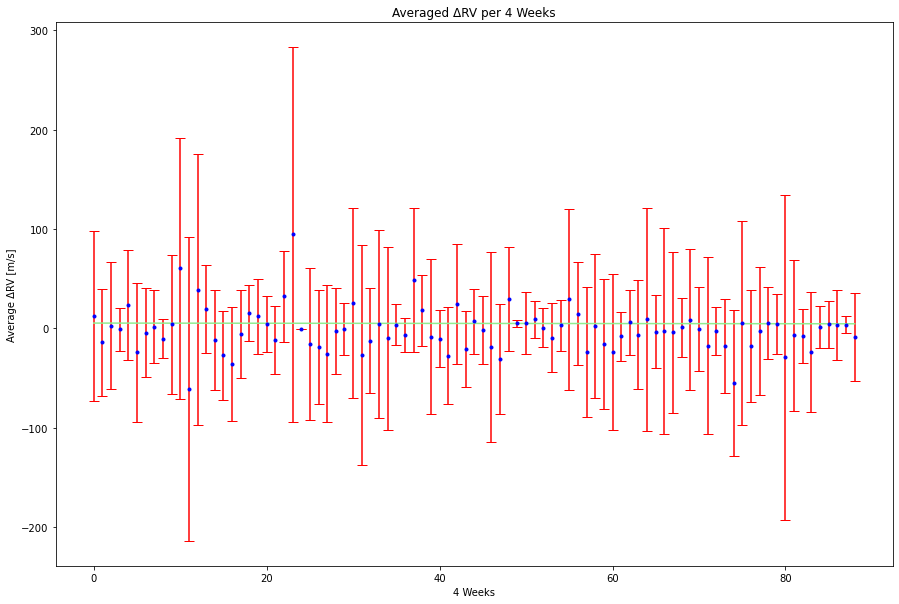

In [133]:
# Plot

x = np.arange(0,89)
y = avg_4weeks2
yerr = avg_4weeks_err2
weight = avg_4weeks_w2 # 1/σ^2
a, b = np.polyfit(x, y, 1, w=weight)
plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('4 Weeks')
plt.ylabel('Average ΔRV [m/s]')
plt.title('Averaged ΔRV per 4 Weeks')
#plt.ylim(10, -10)
print('slope=', a)
print('intercept=', b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, b, a]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 131 seconds.
The acceptance probability does not match the target. It is 0.8851306320573858, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.053  0.082  -0.207    0.099      0.000    0.000   64176.0   69550.0   
b      3.342  4.176  -4.582   11.072      0.016    0.012   64342.0   70608.0   
sigma  0.002  0.000   0.001    0.002      0.000    0.000   83387.0   77942.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

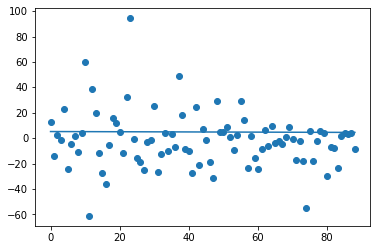

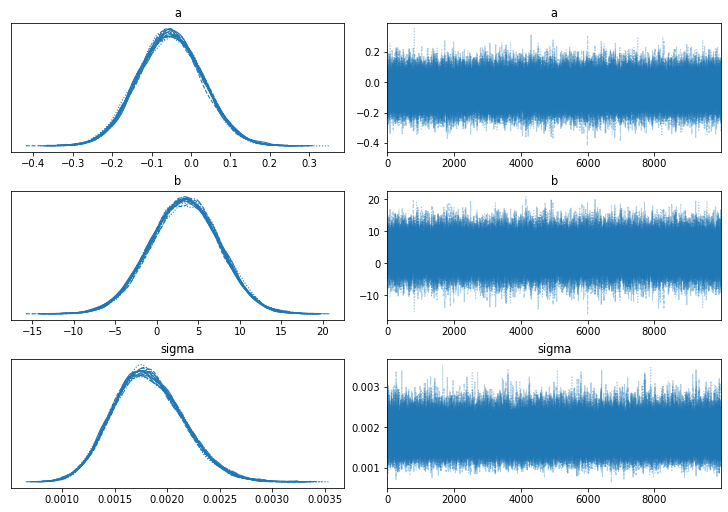

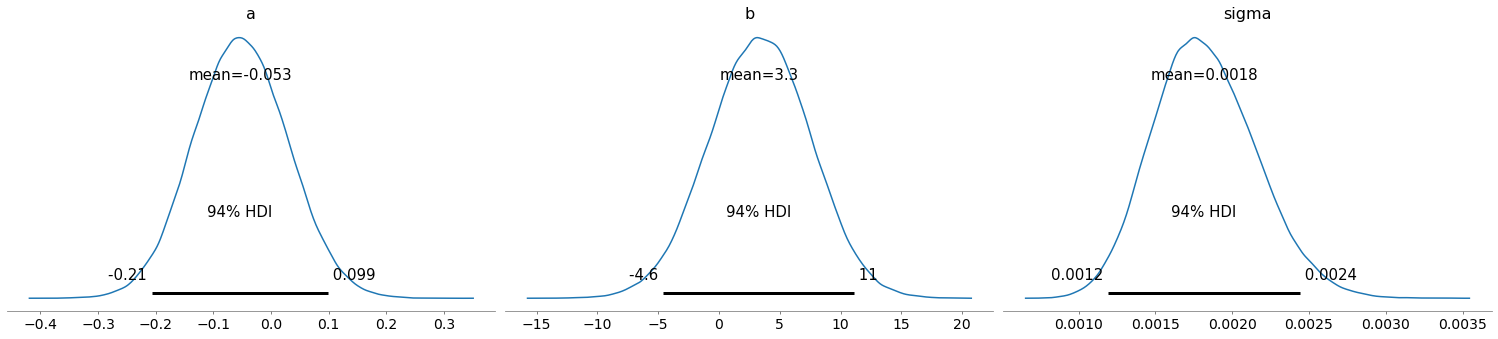

In [134]:
# 28 day binning
n = 89
_b = 5.232883246794111
_a = -0.007787857551686143
_sigma = avg_4weeks_w2
x = np.linspace(0, 88, 89)
y = _a*x + _b
yobs = avg_4weeks2

plt.scatter(x, yobs)
plt.plot(x, y)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    qs = np.sqrt(sigma**2 + np.array(_sigma)**2)
    
    likelihood = pm.Normal('y', mu=b+a*x, tau=qs, observed=yobs)
    
    trace4w = pm.sample(10000, cores=16, return_inferencedata=True)

az.plot_trace(trace4w, figsize=(10, 7))
pm.plot_posterior(trace4w)

pm.summary(trace4w)

In [91]:
max(list(weighted_cut['4 Weeks']))

91.21428571428578

mu: -1.3684597899262858 std: 21.56866250739459


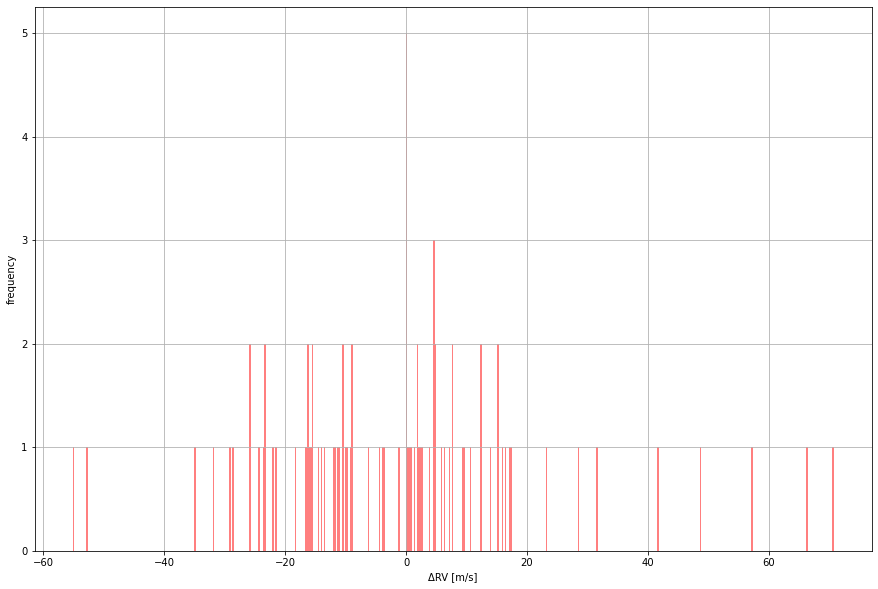

In [75]:
# Distribution of all combined ΔRVs

mua, stda = norm.fit(avg_30d)

plt.figure(figsize=(15,10))
plt.hist(x=avg_30d, bins=500, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
#plt.title('Normalised weighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
#plt.xlim(-200, 200)

### Smoothing

In [55]:
from scipy.signal import savgol_filter

Gradient of slope: -5.765416213220513e-05 [m/MJD]
Polynomial coefficients: -5.765416213220513e-05 3.1372373262830506
Covariance matrix: [[ 1.67549701e-07 -9.75131504e-03]
 [-9.75131504e-03  5.67540038e+02]]
Uncertainty: [4.09328353e-04 2.38230988e+01]


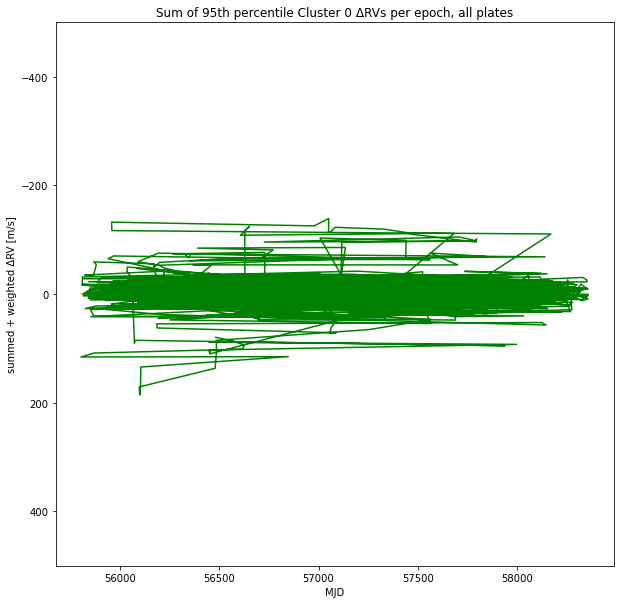

In [56]:
x_cf = weightedavg_df_cutoff['MJD']
y_cf = weightedavg_df_cutoff['Combined ΔRV (m/s)']
yerr_cf = weightedavg_df_cutoff['Combined σRV (m/s)']
yhat = savgol_filter(y_cf, 11, 1)
weights = 1/(yerr_cf**2)
model, cov = np.polyfit(x_cf, y_cf, deg=1, w=weights, cov=True)
a, b = model


# Scatterplot of combined total ΔRVs per epoch, with linear fit

plt.figure(figsize=(10, 10))
#plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='orange')
plt.plot(x_cf, yhat, color='green')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

In [57]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import seaborn as sns

In [58]:
weightedavg_df_cutoff=weightedavg_df_cutoff.rename(columns={"Combined ΔRV (m/s)":"ΔRV"})

In [59]:
weightedavg_df_cutoff

MJD         ΔRV  Combined σRV (m/s)  Cluster                   ISO  \
0     58022.0   -8.053015            0.407374        0  2017-09-26T00:00:00Z   
1     57743.0    0.023227            2.212728        1  2016-12-21T00:00:00Z   
2     56933.0    9.254238            0.147462        0  2014-10-03T00:00:00Z   
3     56936.0   23.920864            0.095845        0  2014-10-06T00:00:00Z   
4     56971.0 -178.377692            0.062524        0  2014-11-10T00:00:00Z   
...       ...         ...                 ...      ...                   ...   
1519  55870.0  -73.029691            0.946294        0  2011-11-05T00:00:00Z   
1520  56617.0   62.421917            1.511150        0  2013-11-21T00:00:00Z   
1521  56625.0   11.459281            0.557512        0  2013-11-29T00:00:00Z   
1522  56576.0   58.248624            0.569609        0  2013-10-11T00:00:00Z   
1523  56482.0  305.706376            0.724491        1  2013-07-09T00:00:00Z   

           Weeks     Months  
0     316.857143  73.933333  
1     277.000000  64.633333  
2     161.285714  37.633333  
3     161.714286  37.733333  
4     166.714286  38.900000  
...          ...        ...  
1519    9.428571   2.200000  
1520  116.142857  27.100000  
1521  117.285714  27.366667  
1522  110.285714  25.733333  
1523   96.857143  22.600000  

[1524 rows x 7 columns]

In [60]:
weightedavg_df_cutoff[ '7day_rolling_avg' ] = weightedavg_df_cutoff.ΔRV.rolling( 7).mean()

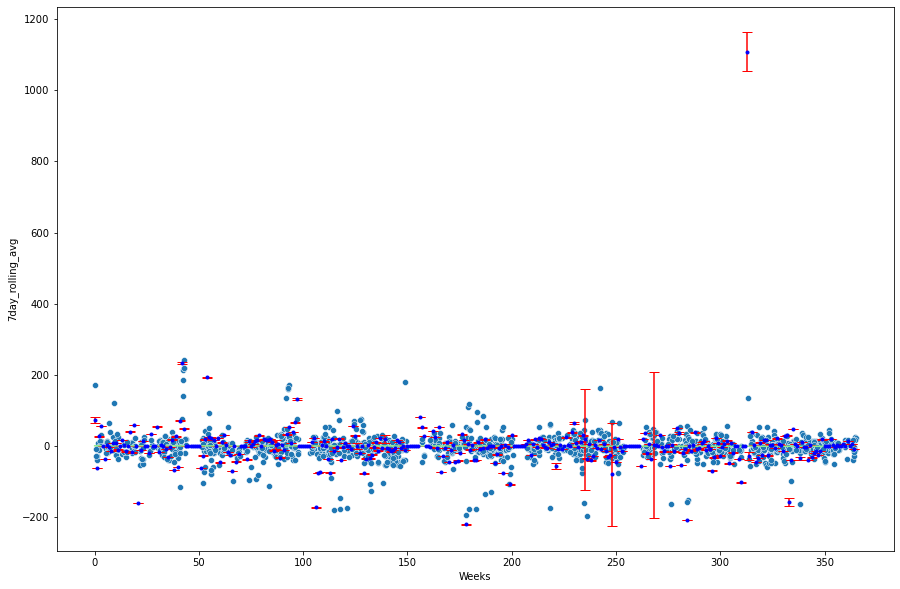

In [61]:
plt.figure(figsize=(15,10))
#sns.scatterplot(x='Weeks', y='ΔRV', data=weightedavg_df_cutoff)
sns.scatterplot(x='Weeks', y='7day_rolling_avg', data=weightedavg_df_cutoff)
x = np.arange(0,365)
y = avg_weeks
yerr = avg_weeks_err
a, b = np.polyfit(x, y, 1)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
#plt.xlabel('Weeks')
#plt.ylabel('Average ΔRV [m/s]')

<AxesSubplot:xlabel='Weeks', ylabel='ΔRV'>

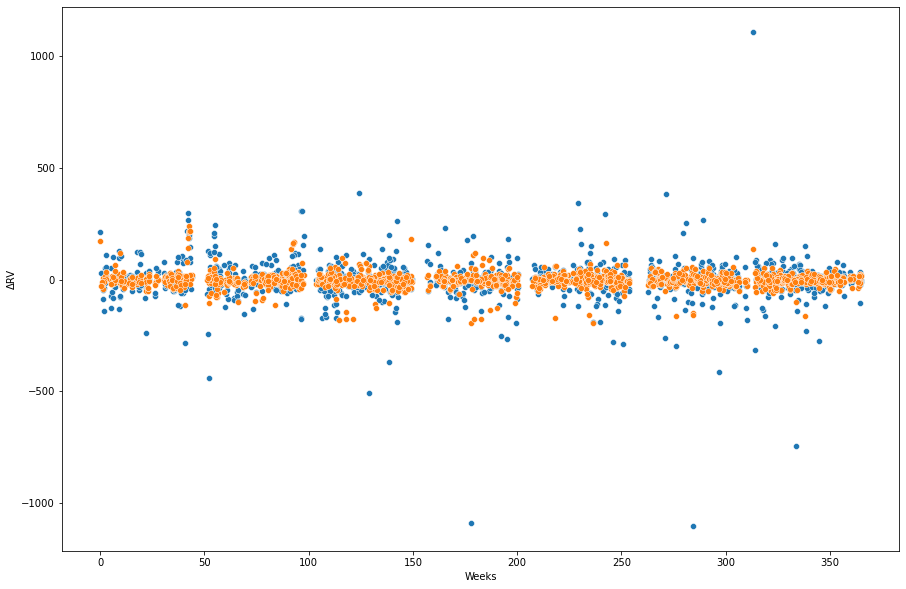

In [62]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='Weeks', y='ΔRV', data=weightedavg_df_cutoff)
sns.scatterplot(x='Weeks', y='7day_rolling_avg', data=weightedavg_df_cutoff)

In [ ]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs = []
combined_staterror = []

for mjd in unique_mjd_list:
    mjd_df = mp_df[mp_df['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    # print('Sum of weights:', sum(weight))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs.append(combined_weightedavg)
    combined_staterror.append(sigmaRV)

In [64]:
from scipy.optimize import curve_fit

In [65]:
def test(x, a, b):
    return a * np.sin(b*x)

In [96]:
param, param_cov = curve_fit(test, x_cf, y_cf)#, sigma=weights)

In [97]:
print("Sine coefficients:", param)
print("Cov of coefficients:", param_cov)

Sine coefficients: [1.06084253 0.99999455]
Cov of coefficients: [[ 9.31972328e+00 -1.15973926e-07]
 [-1.15973926e-07  2.58021651e-09]]


In [98]:
ans = (param[0]*(np.sin(param[1]*x_cf)))

In [99]:
len(ans)

1524

(500.0, -500.0)

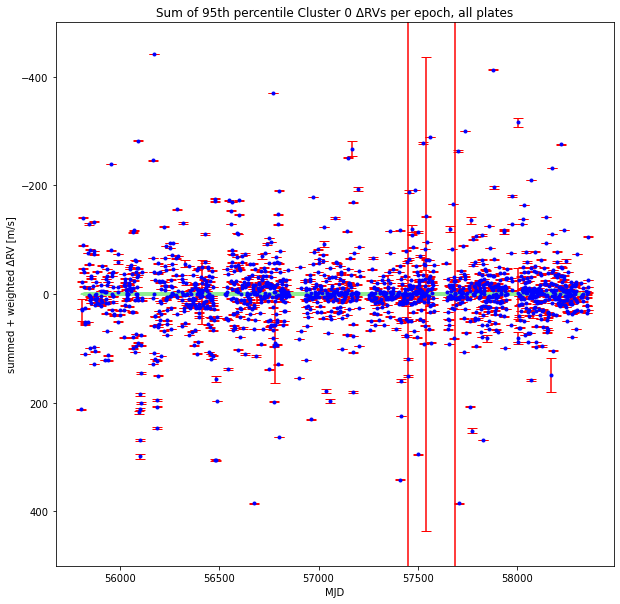

In [103]:
plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, test(x_cf, param[0], param[1]), color='lightgreen')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)
#plt.xlim(56500, 56500.000001)

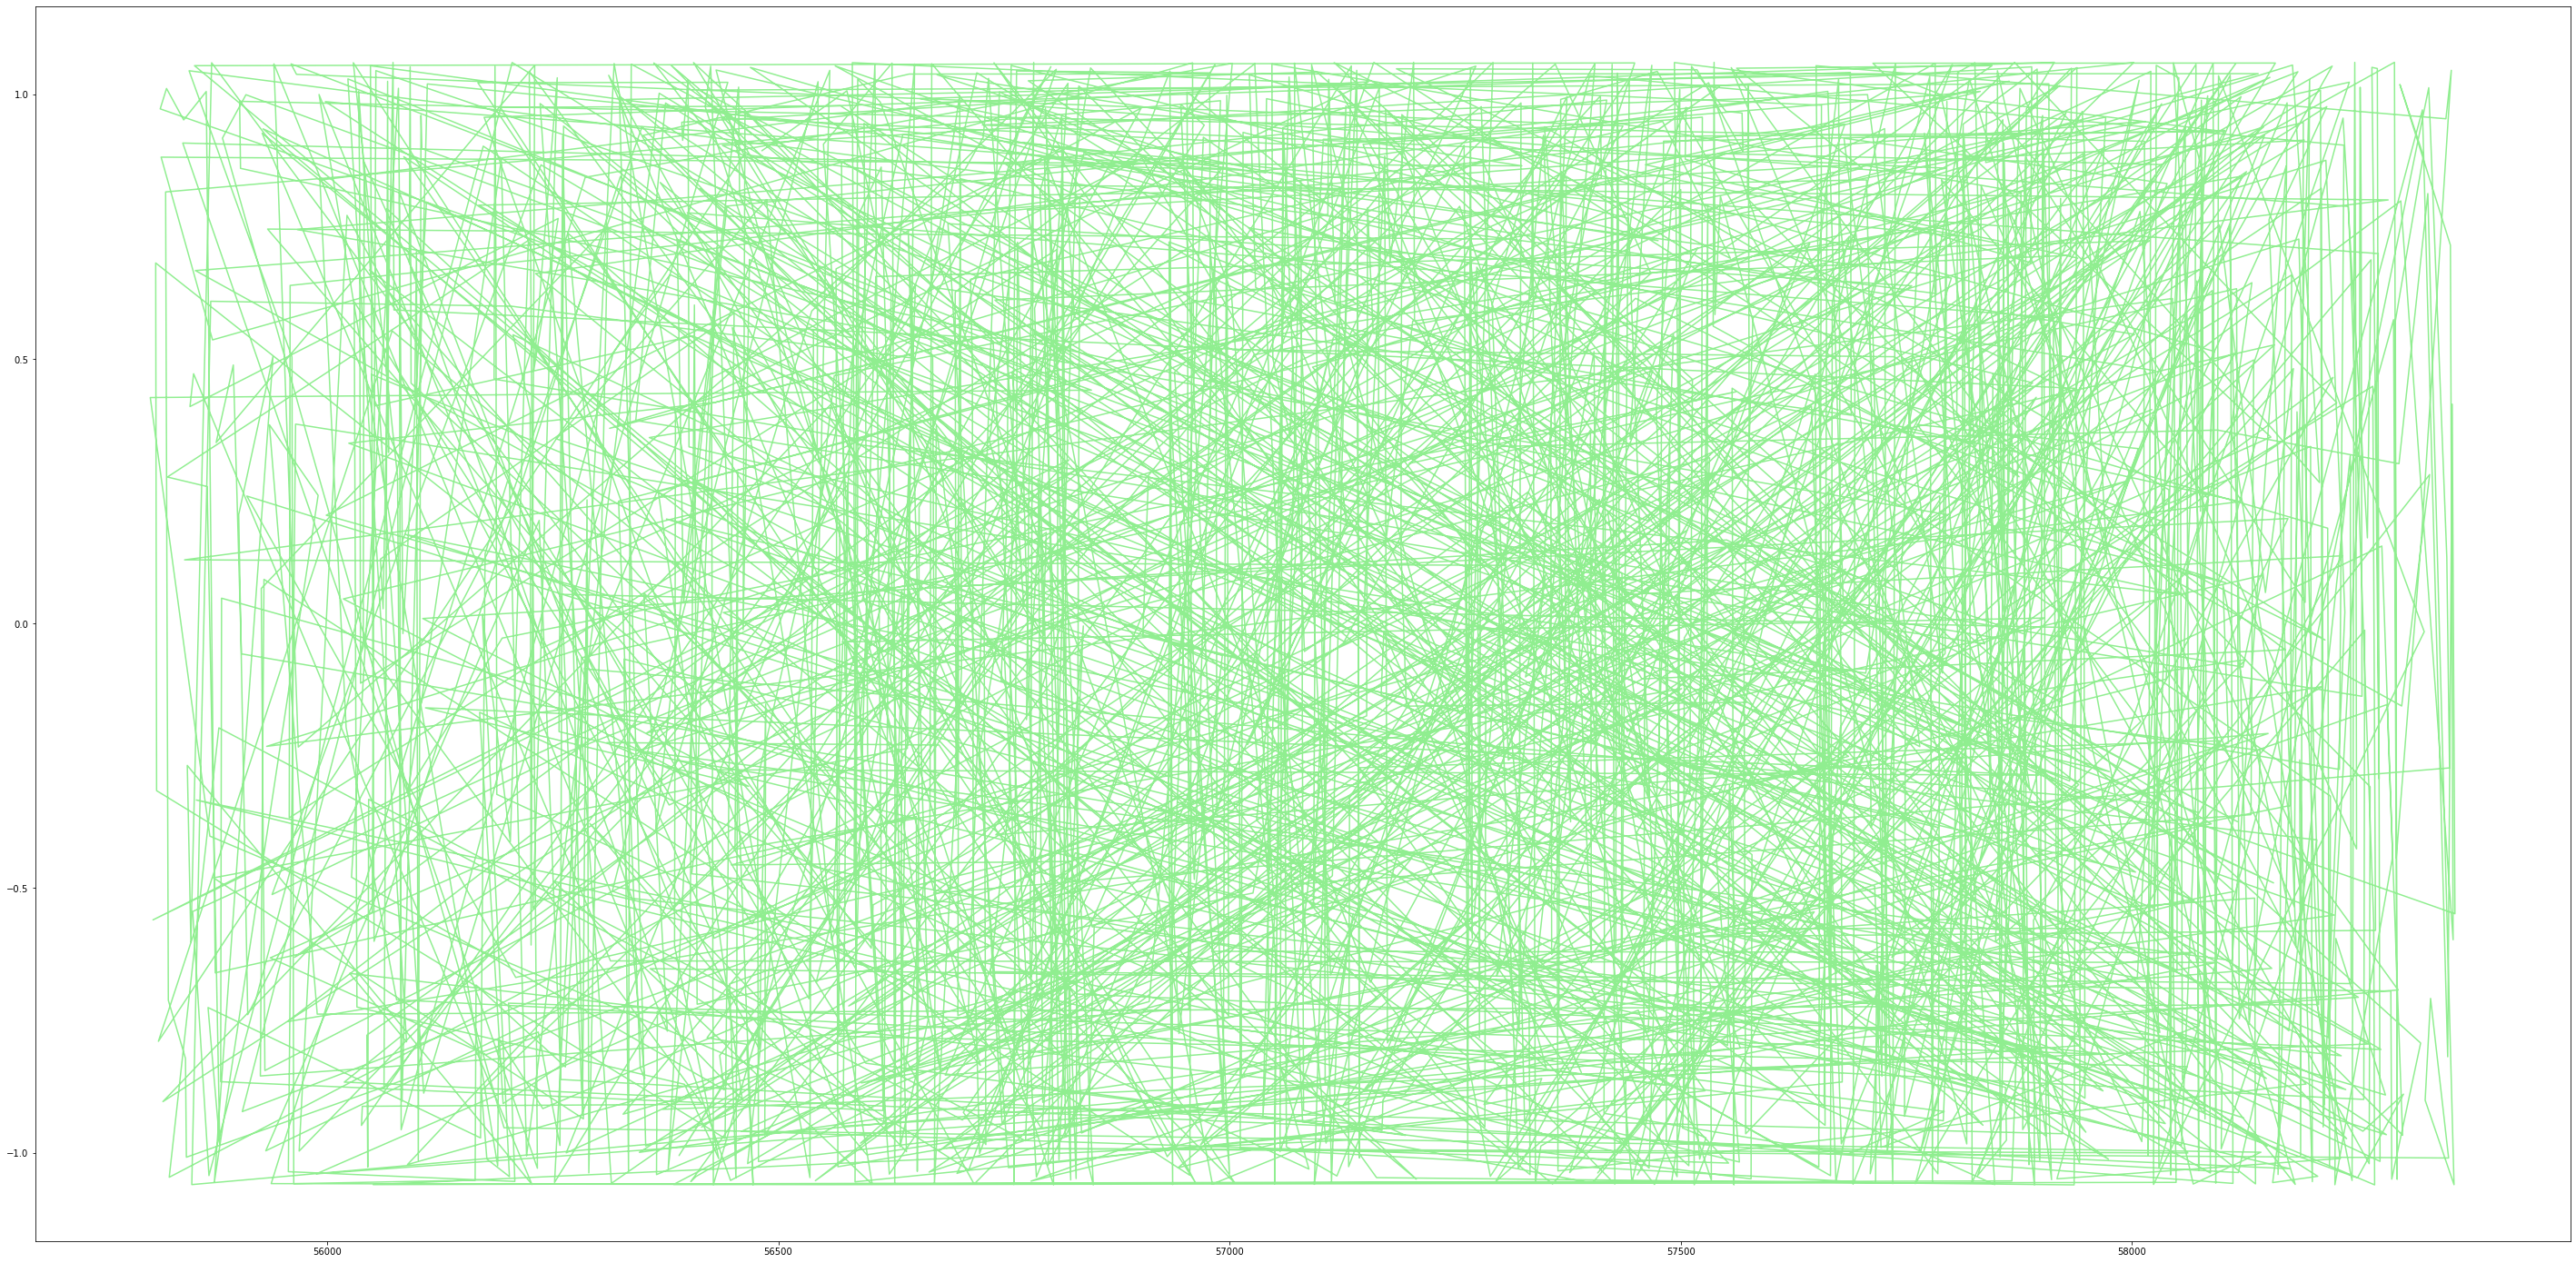

In [104]:
plt.figure(figsize=(50, 25))
plt.plot(x_cf, test(x_cf, param[0], param[1]), color='lightgreen')

mu: -2.351556728498106 std: 84.57216100077585


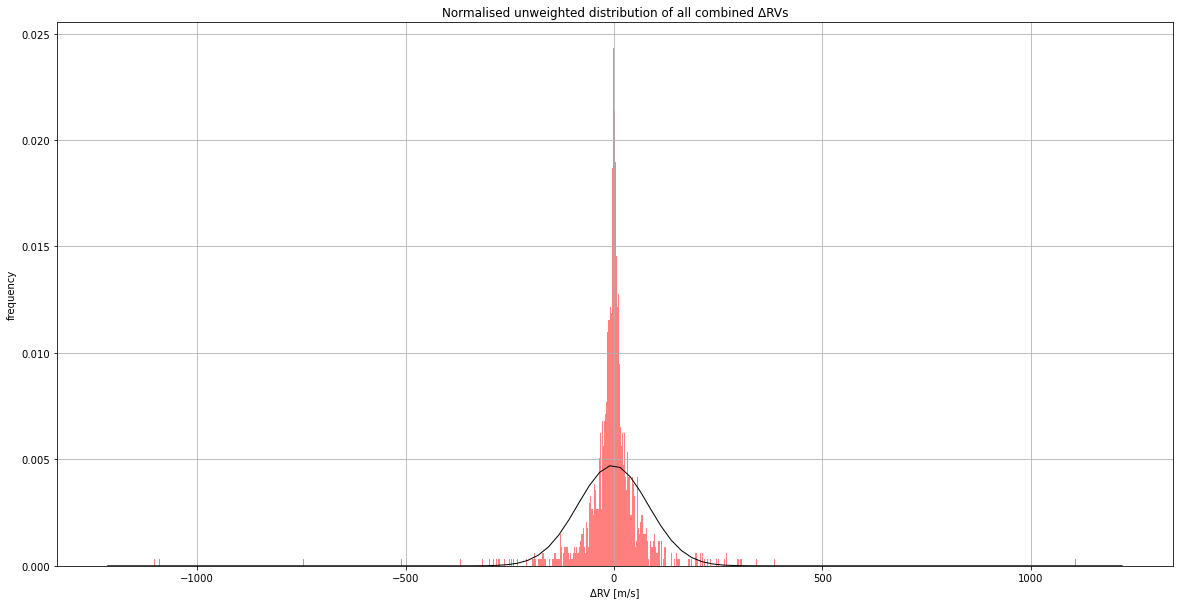

In [63]:
# Normalised unweighted distribution of all combined ΔRVs

mua, stda = norm.fit(weightedavg_df_cutoff['Combined ΔRV (m/s)'])

plt.figure(figsize=(20,10))
plt.hist(x=weightedavg_df_cutoff['Combined ΔRV (m/s)'], bins=1000, alpha=0.5, color='r', label='Cluster 2', density=True, rwidth=1)
xmina, xmaxa = plt.xlim()
xa = np.linspace(xmina, xmaxa, 100)
pa = norm.pdf(xa, mua, stda)  
plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Normalised unweighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)